In [ ]:
import pandas as pd
import pickle

In [ ]:
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import pickle

# Specify the file paths
file_paths = [
    "/content/drive/MyDrive/charbel/X_trn.pkl",
    "/content/drive/MyDrive/charbel/X_vld.pkl",
    "/content/drive/MyDrive/charbel/X_tst.pkl",
    "/content/drive/MyDrive/charbel/X_trn_ref.pkl",
    "/content/drive/MyDrive/charbel/X_vld_ref.pkl",
    "/content/drive/MyDrive/charbel/X_tst_ref.pkl",
    "/content/drive/MyDrive/charbel/y_trn.pkl",
    "/content/drive/MyDrive/charbel/y_vld.pkl",
    "/content/drive/MyDrive/charbel/y_tst.pkl",
]

# Load pickles into DataFrames
dfs = [pd.read_pickle(file_path) for file_path in file_paths]

# Assign meaningful names to DataFrames
X_trn, X_vld, X_tst, X_trn_ref, X_vld_ref, X_tst_ref, y_trn, y_vld, y_tst = dfs


Start here
Stamp  #dubai

In [ ]:
from sklearn.decomposition import FastICA


class MyNewICA:

    def __init__(self, n_PCs=1, loss='mse'):
        self.n_PCs = n_PCs
        if loss not in ['huber', 'mse']:
            raise AttributeError(
                f"The loss should be either 'huber' or 'mse', but {loss} is given"
            )
        else:
            self.loss = loss
        self.model = None

    def set_params(self, **params):
        for param in params.keys():
            setattr(self, param, params[param])
        return self

    def fit(self, X, y):
        X = np.array(X)
        N, K = X.shape
        y = np.array(y).reshape((N, 1))
        self.mu = np.mean(X, axis=0).reshape((1, K))
        self.sigma = np.std(X, axis=0).reshape((1, K))
        self.sigma = np.where(self.sigma == 0, 1, self.sigma)
        X = (X - self.mu) / self.sigma
        ica = FastICA(whiten='unit-variance',random_state=42) #Fix some random number So that the directions remain the same ( otherwise you will get the same span but different directions)
        s_ica = ica.fit(X).transform(X)
        ica_coef = ica.mixing_
        self.original_coef = ica_coef
        self.original_s = s_ica
        # POWER DATA FOR SOURCE ORDERING
        sources_trans = s_ica.T
        squared_source_matrix = np.square(sources_trans)
        squared_A = np.square(ica_coef)
        sum_squared_elements = np.sum(squared_A, axis=0)
        result_matrix = sum_squared_elements.reshape(1, -1)
        qd_matrix =   result_matrix.T * squared_source_matrix
        mean_per_row = np.mean(qd_matrix, axis=1, keepdims=True)
        selected_indices = np.argsort(mean_per_row.flatten())[::-1][:self.n_PCs]
        #GOT A LIST OF SELECTED ORDERS
        self.selected_indices = selected_indices
        self.new_ica_coef = ica_coef[:, selected_indices]
        self.selected_sources = s_ica[:,selected_indices]
        if self.loss == 'mse':
            self.model = LinearRegression().fit( self.selected_sources , y)
        else:
            self.model = HuberRegressor(alpha=0.025).fit( self.selected_sources, y)

        return self

    def predict(self, X):
        X = np.array(X)
        X = (X - self.mu) / self.sigma
        projections = np.dot(X, self.new_ica_coef)
        self.projections = projections
        self.predicted_y = np.dot(projections, self.model.coef_.T) + self.model.intercept_
        return self.predicted_y


In [ ]:
from sklearn.decomposition import FastICA


class MyNewNewICA:

    def __init__(self, n_PCs=1, loss='mse'):
        self.n_PCs = n_PCs
        if loss not in ['huber', 'mse']:
            raise AttributeError(
                f"The loss should be either 'huber' or 'mse', but {loss} is given"
            )
        else:
            self.loss = loss
        self.model = None

    def set_params(self, **params):
        for param in params.keys():
            setattr(self, param, params[param])
        return self

    def fit(self, X, y):
        X = np.array(X)
        N, K = X.shape
        y = np.array(y).reshape((N, 1))
        self.mu = np.mean(X, axis=0).reshape((1, K))
        self.sigma = np.std(X, axis=0).reshape((1, K))
        self.sigma = np.where(self.sigma == 0, 1, self.sigma)
        X = (X - self.mu) / self.sigma
        ica = FastICA(whiten='unit-variance',random_state=42) #Fix some random number So that the directions remain the same ( otherwise you will get the same span but different directions)
        s_ica = ica.fit(X).transform(X)
        ica_coef = ica.mixing_
        self.original_coef = ica_coef
        self.original_s = s_ica
        # POWER DATA FOR SOURCE ORDERING
        sources_trans = s_ica.T
        squared_source_matrix = np.square(sources_trans)
        squared_A = np.square(ica_coef)
        sum_squared_elements = np.sum(squared_A, axis=0)
        result_matrix = sum_squared_elements.reshape(1, -1)
        qd_matrix =   result_matrix.T * squared_source_matrix
        mean_per_row = np.mean(qd_matrix, axis=1, keepdims=True)
        selected_indices = np.argsort(mean_per_row.flatten())[::-1][:self.n_PCs]
        #GOT A LIST OF SELECTED ORDERS
        self.selected_indices = selected_indices
        self.new_ica_coef = ica_coef[:, selected_indices]
        self.selected_sources = s_ica[:,selected_indices]
        if self.loss == 'mse':
            self.model = LinearRegression().fit( self.selected_sources , y)
        else:
            self.model = HuberRegressor(alpha=0.025).fit( self.selected_sources, y)

        return self

    def predict(self, X):
        X = np.array(X)
        X = (X - self.mu) / self.sigma
        suited_X = X.T
        W =  np.linalg.pinv(self.new_ica_coef)
        s_transpose = np.dot(W,suited_X)
        self.projections = s_transpose.T
        self.predicted_y = np.dot(self.projections, self.model.coef_.T) + self.model.intercept_
        return self.predicted_y

Other stamps : First one : CHANGE PREDICT ONLY, SECONND MAKE THE OBSERVED X SIGNALS AND THEN PREDICT IN THE SIGNAL SPACE USING COEF

In [ ]:
params = {'n_PCs':[50],'loss':['mse']}
MyNewICA1 = val_fun(MyNewICA, params=params, X_trn=X_trn, y_trn=y_trn, X_vld=X_vld, y_vld=y_vld, sleep=3)

print("\n\n selected indeces : " ,MyNewICA1.selected_indices)
print("\n\n\n\n\n New coefs : ", MyNewICA1.new_ica_coef)
print("with shape",MyNewICA1.new_ica_coef.shape)
print("\n\n Old coefs : ", MyNewICA1.original_coef)
print("with shape",MyNewICA1.original_coef.shape)
print("\n\n selected sources : " ,MyNewICA1.selected_sources)
print("with shape",MyNewICA1.selected_sources.shape)
print("\n\n Original sources : " ,MyNewICA1.original_s)
print("with shape", MyNewICA1.original_s.shape)
print("\n\n Projections : " ,MyNewICA1.projections)
print("\nwith shape", MyNewICA1.projections.shape)
print("\n\n\nand model coef ", MyNewICA1.model.coef_)
print("\nwith shape ", MyNewICA1.model.coef_.shape)
print("\n\n and intercept", MyNewICA1.model.intercept_)
print("and the predicted y is ", MyNewICA1.predicted_y)
evaluate(y_tst, MyNewICA1.predict(X_tst))

# For MyNewICA2 with n_PCs = [10]
params = {'n_PCs':[50],'loss':['mse']}
MyNewICA2 = val_fun(MyNewNewICA, params=params, X_trn=X_trn, y_trn=y_trn, X_vld=X_vld, y_vld=y_vld, sleep=3)

print("\n\n selected indeces : " ,MyNewICA2.selected_indices)
print("\n\n\n\n\n New coefs : ", MyNewICA2.new_ica_coef)
print("with shape",MyNewICA2.new_ica_coef.shape)
print("\n\n Old coefs : ", MyNewICA2.original_coef)
print("with shape",MyNewICA2.original_coef.shape)
print("\n\n selected sources : " ,MyNewICA2.selected_sources)
print("with shape",MyNewICA2.selected_sources.shape)
print("\n\n Original sources : " ,MyNewICA2.original_s)
print("with shape", MyNewICA2.original_s.shape)
print("\n\n Projections : " ,MyNewICA2.projections)
print("\nwith shape", MyNewICA2.projections.shape)
print("\n\n\nand model coef ", MyNewICA2.model.coef_)
print("\nwith shape ", MyNewICA2.model.coef_.shape)
print("\n\n\nand model coef ", MyNewICA2.model.intercept_)
print("and the predicted y is ", MyNewICA2.predicted_y)  ######
evaluate(y_tst, MyNewICA2.predict(X_tst))



Model with params: {'loss': 'mse', 'n_PCs': 50} finished.
with out-of-sample MSE on validation set: 0.00870
with out-of-sample R-squared on validation set: 0.6100814%
************************************************************

############################################################
Tuning process finished!!!
The best setting is: {'loss': 'mse', 'n_PCs': 50}
with MSE OOS 0.00870 on validation set.
############################################################


 selected indeces :  [535 298 460 516 252 721 647 487   3 678 141 778 687 100 761 357 566 547
 722 331 588 599   6 313 135 245 795 349 517 784 887 845 587 278 465 157
 480 491 529 799 867 353 811 287 403 292 404 310 823 550]





 New coefs :  [[ 6.07944360e-34 -3.06689303e-34 -2.41983058e-34 ...  5.12559815e-36
  -5.10688942e-36 -5.05303183e-36]
 [ 1.60212338e-31 -8.08222155e-32 -6.37700981e-32 ...  1.35075529e-33
  -1.34582496e-33 -1.33163180e-33]
 [ 6.81208910e-35 -3.43649024e-35 -2.71144905e-35 ...  5.74329390e-37
  -5.7

In [ ]:
params = {'n_PCs':[10],'loss':['mse']}
MyNewICA3 = val_fun(MyNewICA, params=params, X_trn=X_trn, y_trn=y_trn, X_vld=X_vld, y_vld=y_vld, sleep=3)

print("\n\n selected indeces : " ,MyNewICA3.selected_indices)
print("\n\n\n\n\n New coefs : ", MyNewICA3.new_ica_coef)
print("with shape",MyNewICA3.new_ica_coef.shape)
print("\n\n Old coefs : ", MyNewICA3.original_coef)
print("with shape",MyNewICA3.original_coef.shape)
print("\n\n selected sources : " ,MyNewICA3.selected_sources)
print("with shape",MyNewICA3.selected_sources.shape)
print("\n\n Original sources : " ,MyNewICA3.original_s)
print("with shape", MyNewICA3.original_s.shape)
print("\n\n Projections : " ,MyNewICA3.projections)
print("\nwith shape", MyNewICA3.projections.shape)
print("\n\n\nand model coef ", MyNewICA3.model.coef_)
print("\nwith shape ", MyNewICA3.model.coef_.shape)
print("\n\n and intercept", MyNewICA3.model.intercept_)
print("and the predicted y is ", MyNewICA3.predicted_y)
evaluate(y_tst, MyNewICA3.predict(X_tst))

Model with params: {'loss': 'mse', 'n_PCs': 10} finished.
with out-of-sample MSE on validation set: 0.00870
with out-of-sample R-squared on validation set: 0.6100814%
************************************************************

############################################################
Tuning process finished!!!
The best setting is: {'loss': 'mse', 'n_PCs': 10}
with MSE OOS 0.00870 on validation set.
############################################################


 selected indeces :  [535 298 460 516 252 721 647 487   3 678]





 New coefs :  [[ 6.07944360e-34 -3.06689303e-34 -2.41983058e-34 ... -1.03125919e-35
   9.93571853e-36 -9.45334872e-36]
 [ 1.60212338e-31 -8.08222155e-32 -6.37700981e-32 ... -2.71769025e-33
   2.61837233e-33 -2.49125281e-33]
 [ 6.81208910e-35 -3.43649024e-35 -2.71144905e-35 ... -1.15553823e-36
   1.11330912e-36 -1.05925901e-36]
 ...
 [-6.64039437e-35  3.34987551e-35  2.64310856e-35 ...  1.12641357e-36
  -1.08524881e-36  1.03256100e-36]
 [ 1.76714315e-33 -8.91

In [ ]:
from sklearn.decomposition import FastICA


class MyOtherICA:

    def __init__(self, n_PCs=1, loss='mse'):
        self.n_PCs = n_PCs
        if loss not in ['huber', 'mse']:
            raise AttributeError(
                f"The loss should be either 'huber' or 'mse', but {loss} is given"
            )
        else:
            self.loss = loss
        self.model = None

    def set_params(self, **params):
        for param in params.keys():
            setattr(self, param, params[param])
        return self

    def fit(self, X, y):
        X = np.array(X)
        N, K = X.shape
        y = np.array(y).reshape((N, 1))
        self.mu = np.mean(X, axis=0).reshape((1, K))
        self.sigma = np.std(X, axis=0).reshape((1, K))
        self.sigma = np.where(self.sigma == 0, 1, self.sigma)
        X = (X - self.mu) / self.sigma
        ica = FastICA(whiten='unit-variance',random_state=42) #Fix some random number So that the directions remain the same ( otherwise you will get the same span but different directions)
        s_ica = ica.fit(X).transform(X)
        ica_coef = ica.mixing_
        self.original_coef = ica_coef
        self.original_s = s_ica
        # POWER DATA FOR SOURCE ORDERING
        sources_trans = s_ica.T
        squared_source_matrix = np.square(sources_trans)
        squared_A = np.square(ica_coef)
        sum_squared_elements = np.sum(squared_A, axis=0)
        result_matrix = sum_squared_elements.reshape(1, -1)
        qd_matrix =   result_matrix.T * squared_source_matrix
        mean_per_row = np.mean(qd_matrix, axis=1, keepdims=True)
        selected_indices = np.argsort(mean_per_row.flatten())[::-1][:self.n_PCs]
        #GOT A LIST OF SELECTED ORDERS
        self.selected_indices = selected_indices
        self.new_ica_coef = ica_coef[:, selected_indices]
        self.selected_sources = s_ica[:,selected_indices]
        if self.loss == 'mse':
            self.model = LinearRegression().fit( self.selected_sources , y)
        else:
            self.model = HuberRegressor(alpha=0.025).fit( self.selected_sources, y)

        return self

    def predict(self, X):
        X = np.array(X)
        X = (X - self.mu) / self.sigma
        projections = np.dot(X, self.new_ica_coef)
        self.projections = projections
        return self.model.predict(projections)


In [ ]:
params = {'n_PCs':[4],'loss':['mse']}
MyNewICA4 = val_fun(MyNewNewICA, params=params, X_trn=X_trn, y_trn=y_trn, X_vld=X_vld, y_vld=y_vld, sleep=3)

print("\n\n selected indeces : " ,MyNewICA4.selected_indices)
print("\n\n\n\n\n New coefs : ", MyNewICA4.new_ica_coef)
print("with shape",MyNewICA4.new_ica_coef.shape)
print("\n\n Old coefs : ", MyNewICA4.original_coef)
print("with shape",MyNewICA4.original_coef.shape)
print("\n\n selected sources : " ,MyNewICA4.selected_sources)
print("with shape",MyNewICA4.selected_sources.shape)
print("\n\n Original sources : " ,MyNewICA4.original_s)
print("with shape", MyNewICA4.original_s.shape)
print("\n\n Projections : " ,MyNewICA4.projections)
print("\nwith shape", MyNewICA4.projections.shape)
print("\n\n\nand model coef ", MyNewICA4.model.coef_)
print("\nwith shape ", MyNewICA4.model.coef_.shape)
print("\n\n\nand model coef ", MyNewICA4.model.intercept_)
print("and the predicted y is ", MyNewICA4.predicted_y)  ######
evaluate(y_tst, MyNewICA4.predict(X_tst))


Model with params: {'loss': 'mse', 'n_PCs': 4} finished.
with out-of-sample MSE on validation set: 0.01223
with out-of-sample R-squared on validation set: -38.6701506%
************************************************************

############################################################
Tuning process finished!!!
The best setting is: {'loss': 'mse', 'n_PCs': 4}
with MSE OOS 0.01223 on validation set.
############################################################


 selected indeces :  [535 298 460 516]





 New coefs :  [[ 6.07944360e-34 -3.06689303e-34 -2.41983058e-34  8.63183388e-35]
 [ 1.60212338e-31 -8.08222155e-32 -6.37700981e-32  2.27475798e-32]
 [ 6.81208910e-35 -3.43649024e-35 -2.71144905e-35  9.67207288e-36]
 ...
 [-6.64039437e-35  3.34987551e-35  2.64310856e-35 -9.42829393e-36]
 [ 1.76714315e-33 -8.91469577e-34 -7.03384607e-34  2.50905957e-34]
 [ 2.30774216e-33 -1.16418521e-33 -9.18561867e-34  3.27662337e-34]]
with shape (912, 4)


 Old coefs :  [[-5.63470685e-37 -3.1446474

In [ ]:
params = {'n_PCs':[100,200],'loss':['mse']}
MyNewICA5 = val_fun(MyNewICA, params=params, X_trn=X_trn, y_trn=y_trn, X_vld=X_vld, y_vld=y_vld, sleep=3)

print("\n\n selected indeces : " ,MyNewICA5.selected_indices)
print("\n\n\n\n\n New coefs : ", MyNewICA5.new_ica_coef)
print("with shape",MyNewICA5.new_ica_coef.shape)
print("\n\n Old coefs : ", MyNewICA5.original_coef)
print("with shape",MyNewICA5.original_coef.shape)
print("\n\n selected sources : " ,MyNewICA5.selected_sources)
print("with shape",MyNewICA5.selected_sources.shape)
print("\n\n Original sources : " ,MyNewICA5.original_s)
print("with shape", MyNewICA5.original_s.shape)
print("\n\n Projections : " ,MyNewICA5.projections)
print("\nwith shape", MyNewICA5.projections.shape)
print("\n\n\nand model coef ", MyNewICA5.model.coef_)
print("\nwith shape ", MyNewICA5.model.coef_.shape)
print("\n\n and intercept", MyNewICA5.model.intercept_)
print("and the predicted y is ", MyNewICA5.predicted_y)
evaluate(y_tst, MyNewICA5.predict(X_tst))

Model with params: {'loss': 'mse', 'n_PCs': 100} finished.
with out-of-sample MSE on validation set: 0.00870
with out-of-sample R-squared on validation set: 0.6100814%
************************************************************
Model with params: {'loss': 'mse', 'n_PCs': 200} finished.
with out-of-sample MSE on validation set: 0.00870
with out-of-sample R-squared on validation set: 0.6100814%
************************************************************

############################################################
Tuning process finished!!!
The best setting is: {'loss': 'mse', 'n_PCs': 100}
with MSE OOS 0.00870 on validation set.
############################################################


 selected indeces :  [535 298 460 516 252 721 647 487   3 678 141 778 687 100 761 357 566 547
 722 331 588 599   6 313 135 245 795 349 517 784 887 845 587 278 465 157
 480 491 529 799 867 353 811 287 403 292 404 310 823 550 254 758 589 615
 318 340  40 161 308 316 590 886 526 817 351 655 407 120 81

In [ ]:
params = {'n_PCs':[50],'loss':['huber']}
MyNewICA6 = val_fun(MyNewICA, params=params, X_trn=X_trn, y_trn=y_trn, X_vld=X_vld, y_vld=y_vld, sleep=3)

print("\n\n selected indeces : " ,MyNewICA6.selected_indices)
print("\n\n\n\n\n New coefs : ", MyNewICA6.new_ica_coef)
print("with shape",MyNewICA6.new_ica_coef.shape)
print("\n\n Old coefs : ", MyNewICA6.original_coef)
print("with shape",MyNewICA6.original_coef.shape)
print("\n\n selected sources : " ,MyNewICA6.selected_sources)
print("with shape",MyNewICA6.selected_sources.shape)
print("\n\n Original sources : " ,MyNewICA6.original_s)
print("with shape", MyNewICA6.original_s.shape)
print("\n\n Projections : " ,MyNewICA6.projections)
print("\nwith shape", MyNewICA6.projections.shape)
print("\n\n\nand model coef ", MyNewICA6.model.coef_)
print("\nwith shape ", MyNewICA6.model.coef_.shape)
print("\n\n and intercept", MyNewICA6.model.intercept_)
print("and the predicted y is ", MyNewICA6.predicted_y)
evaluate(y_tst, MyNewICA6.predict(X_tst))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model with params: {'loss': 'huber', 'n_PCs': 50} finished.
with out-of-sample MSE on validation set: 0.00861
with out-of-sample R-squared on validation set: 1.6991399%
************************************************************

############################################################
Tuning process finished!!!
The best setting is: {'loss': 'huber', 'n_PCs': 50}
with MSE OOS 0.00861 on validation set.
############################################################


 selected indeces :  [535 298 460 516 252 721 647 487   3 678 141 778 687 100 761 357 566 547
 722 331 588 599   6 313 135 245 795 349 517 784 887 845 587 278 465 157
 480 491 529 799 867 353 811 287 403 292 404 310 823 550]





 New coefs :  [[ 6.07944360e-34 -3.06689303e-34 -2.41983058e-34 ...  5.12559815e-36
  -5.10688942e-36 -5.05303183e-36]
 [ 1.60212338e-31 -8.08222155e-32 -6.37700981e-32 ...  1.35075529e-33
  -1.34582496e-33 -1.33163180e-33]
 [ 6.81208910e-35 -3.43649024e-35 -2.71144905e-35 ...  5.74329390e-37
  

HERE HERE
# STAMP

In [ ]:
params = {'n_PCs':[50],'loss':['mse']}
MyNewICA1 = val_fun(MyNewICA, params=params, X_trn=X_trn, y_trn=y_trn, X_vld=X_vld, y_vld=y_vld, sleep=3)

print("\n\n selected indeces : " ,MyNewICA1.selected_indices)
print("\n\n\n\n\n New coefs : ", MyNewICA1.new_ica_coef)
print("with shape",MyNewICA1.new_ica_coef.shape)
print("\n\n Old coefs : ", MyNewICA1.original_coef)
print("with shape",MyNewICA1.original_coef.shape)
print("\n\n selected sources : " ,MyNewICA1.selected_sources)
print("with shape",MyNewICA1.selected_sources.shape)
print("\n\n Original sources : " ,MyNewICA1.original_s)
print("with shape", MyNewICA1.original_s.shape)
print("\n\n Projections : " ,MyNewICA1.projections)
print("\nwith shape", MyNewICA1.projections.shape)
print("\n\n\nand model coef ", MyNewICA1.model.coef_)
print("\nwith shape ", MyNewICA1.model.coef_.shape)
evaluate(y_tst, MyNewICA1.predict(X_tst))

# For MyNewICA2 with n_PCs = [10]
params = {'n_PCs':[10],'loss':['mse']}
MyNewICA2 = val_fun(MyNewICA, params=params, X_trn=X_trn, y_trn=y_trn, X_vld=X_vld, y_vld=y_vld, sleep=3)

print("\n\n selected indeces : " ,MyNewICA2.selected_indices)
print("\n\n\n\n\n New coefs : ", MyNewICA2.new_ica_coef)
print("with shape",MyNewICA2.new_ica_coef.shape)
print("\n\n Old coefs : ", MyNewICA2.original_coef)
print("with shape",MyNewICA2.original_coef.shape)
print("\n\n selected sources : " ,MyNewICA2.selected_sources)
print("with shape",MyNewICA2.selected_sources.shape)
print("\n\n Original sources : " ,MyNewICA2.original_s)
print("with shape", MyNewICA2.original_s.shape)
print("\n\n Projections : " ,MyNewICA2.projections)
print("\n\n Projections : " ,MyNewICA1.projections)
print("\nwith shape", MyNewICA2.projections.shape)
print("\n\n\nand model coef ", MyNewICA2.model.coef_)
print("\nwith shape ", MyNewICA2.model.coef_.shape)
evaluate(y_tst, MyNewICA2.predict(X_tst))

self.projections

Model with params: {'loss': 'mse', 'n_PCs': 50} finished.
with out-of-sample MSE on validation set: 0.00870
with out-of-sample R-squared on validation set: 0.6100814%
************************************************************

############################################################
Tuning process finished!!!
The best setting is: {'loss': 'mse', 'n_PCs': 50}
with MSE OOS 0.00870 on validation set.
############################################################


 selected indeces :  [535 298 460 516 252 721 647 487   3 678 141 778 687 100 761 357 566 547
 722 331 588 599   6 313 135 245 795 349 517 784 887 845 587 278 465 157
 480 491 529 799 867 353 811 287 403 292 404 310 823 550]





 New coefs :  [[ 6.07944360e-34 -3.06689303e-34 -2.41983058e-34 ...  5.12559815e-36
  -5.10688942e-36 -5.05303183e-36]
 [ 1.60212338e-31 -8.08222155e-32 -6.37700981e-32 ...  1.35075529e-33
  -1.34582496e-33 -1.33163180e-33]
 [ 6.81208910e-35 -3.43649024e-35 -2.71144905e-35 ...  5.74329390e-37
  -5.7

NameError: name 'self' is not defined

In [ ]:
from sklearn.decomposition import FastICA


class MyOtherICA:

    def __init__(self, n_PCs=1, loss='mse'):
        self.n_PCs = n_PCs
        if loss not in ['huber', 'mse']:
            raise AttributeError(
                f"The loss should be either 'huber' or 'mse', but {loss} is given"
            )
        else:
            self.loss = loss
        self.model = None

    def set_params(self, **params):
        for param in params.keys():
            setattr(self, param, params[param])
        return self

    def fit(self, X, y):
        X = np.array(X)
        N, K = X.shape
        y = np.array(y).reshape((N, 1))
        self.mu = np.mean(X, axis=0).reshape((1, K))
        self.sigma = np.std(X, axis=0).reshape((1, K))
        self.sigma = np.where(self.sigma == 0, 1, self.sigma)
        X = (X - self.mu) / self.sigma
        ica = FastICA(whiten='unit-variance',random_state=42) #Fix some random number So that the directions remain the same ( otherwise you will get the same span but different directions)
        s_ica = ica.fit(X).transform(X)
        ica_coef = ica.mixing_
        self.original_coef = ica_coef
        self.original_s = s_ica
        # POWER DATA FOR SOURCE ORDERING
        sources_trans = s_ica.T
        squared_source_matrix = np.square(sources_trans)
        squared_A = np.square(ica_coef)
        sum_squared_elements = np.sum(squared_A, axis=0)
        result_matrix = sum_squared_elements.reshape(1, -1)
        qd_matrix =   result_matrix.T * squared_source_matrix
        mean_per_row = np.mean(qd_matrix, axis=1, keepdims=True)
        selected_indices = np.argsort(mean_per_row.flatten())[::-1][:self.n_PCs]
        #GOT A LIST OF SELECTED ORDERS
        self.selected_indices = selected_indices
        self.new_ica_coef = ica_coef[:, selected_indices]
        self.selected_sources = s_ica[:,selected_indices]
        if self.loss == 'mse':
            self.model = LinearRegression().fit( self.selected_sources , y)
        else:
            self.model = HuberRegressor(alpha=0.025).fit( self.selected_sources, y)

        return self

    def predict(self, X):
        X = np.array(X)
        X = (X - self.mu) / self.sigma
        X = X @ self.new_ica_coef
        return self.model.predict(X)


In [ ]:
class MyPCR:

    def __init__(self,n_PCs=1,loss='mse'):
        self.n_PCs = n_PCs
        if loss not in ['huber','mse']:
            raise AttributeError(
            f"The loss should be either 'huber' or 'mse', but {loss} is given"
            )
        else:
            self.loss = loss

    def set_params(self, **params):
        for param in params.keys():
            setattr(self, param, params[param])
        return self

    def fit(self,X,y):
        X = np.array(X)
        N,K = X.shape
        y = np.array(y_trn).reshape((N,1))
        self.mu = np.mean(X,axis=0).reshape((1,K))
        self.sigma = np.std(X,axis=0).reshape((1,K))
        self.sigma = np.where(self.sigma==0,1,self.sigma)
        X = (X-self.mu)/self.sigma  #standardize
        pca = PCA()   #call the sklearn class
        X = pca.fit_transform(X)[:,:self.n_PCs]  #Projected x ( Q-dimensional)
        self.pc_coef = pca.components_.T[:,:self.n_PCs]   #P by Q factor loading
        if self.loss == 'mse':
            self.model = LinearRegression().fit(X,y)    #fit the low dimensional data
        else:
            self.model = HuberRegressor().fit(X,y)
        return self

    def predict(self,X):
        X = np.array(X)
        X = (X-self.mu)/self.sigma
        X = X @ self.pc_coef
        return self.model.predict(X)

STAMP

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import ParameterGrid
import time
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
class PCRegressor:

    def __init__(self,n_PCs=1,loss='mse'):
        self.n_PCs = n_PCs
        if loss not in ['huber','mse']:
            raise AttributeError(
            f"The loss should be either 'huber' or 'mse', but {loss} is given"
            )
        else:
            self.loss = loss

    def set_params(self, **params):
        for param in params.keys():
            setattr(self, param, params[param])
        return self

    def fit(self,X,y):
        X = np.array(X)
        N,K = X.shape
        y = np.array(y_trn).reshape((N,1))
        self.mu = np.mean(X,axis=0).reshape((1,K))
        self.sigma = np.std(X,axis=0).reshape((1,K))
        self.sigma = np.where(self.sigma==0,1,self.sigma)
        X = (X-self.mu)/self.sigma  #standardize
        pca = PCA()   #call the sklearn class
        X = pca.fit_transform(X)[:,:self.n_PCs]  #Projected x ( Q-dimensional)
        self.pc_coef = pca.components_.T[:,:self.n_PCs]   #P by Q factor loading
        if self.loss == 'mse':
            self.model = LinearRegression().fit(X,y)    #fit the low dimensional data
        else:
            self.model = HuberRegressor().fit(X,y)
        return self

    def predict(self,X):
        X = np.array(X)
        X = (X-self.mu)/self.sigma
        X = X @ self.pc_coef
        return self.model.predict(X)

STAMP STAMP : THERE WAS AN ERROR HERE : I FIXED IT . BUT THERE MIGHT BE ANOTHER SIMILAR ERROR . IF MSE < BEST_MSE ........
STAMP    SEE IN VALIDATION FUNCTION

Ideally I would like to use the R-squared function used previously ( i.e. the commented function below); However, this function is computationally expensive, as it can consume mroe than 50gb RAM if used in PCR.

In [ ]:

'''
def R_oos(actual, predicted, actual_mean):
    actual, predicted = np.array(actual), np.array(predicted)
    return 1 - (np.dot((actual - predicted), (actual - predicted))) / np.dot((actual - actual_mean), (actual - actual_mean))
'''


STAMP : MODIFY ROOS - RAM UNITS

In [ ]:
def R_oos(actual, predicted):
    actual, predicted = np.array(actual), np.array(predicted).flatten()
    predicted = np.where(predicted<0,0,predicted)
    return 1 - (np.dot((actual-predicted),(actual-predicted)))/(np.dot(actual,actual))

def val_fun(model, params: dict, X_trn, y_trn, X_vld, y_vld, illustration=True, sleep=0):
    best_mse_oos = None
    lst_params = list(ParameterGrid(params))
    for param in lst_params:
        if best_mse_oos == None:
            mod = model().set_params(**param).fit(X_trn, y_trn)
            best_mod = mod
            y_pred = mod.predict(X_vld)
            best_ros = R_oos(y_vld, y_pred)
            best_mse_oos = mean_squared_error(y_vld,y_pred)
            best_param = param
            if illustration:
                print(f'Model with params: {param} finished.')
                print(f'with out-of-sample MSE on validation set: {best_mse_oos:.5f}')
                print(f'with out-of-sample R-squared on validation set: {best_ros*100:.7f}%')
                print('*'*60)
        else:
            time.sleep(sleep)
            mod = model().set_params(**param).fit(X_trn, y_trn)
            y_pred = mod.predict(X_vld)
            ros = R_oos(y_vld, y_pred)
            mse_oos = mean_squared_error(y_vld,y_pred)
            if illustration:
                print(f'Model with params: {param} finished.')
                print(f'with out-of-sample MSE on validation set: {mse_oos:.5f}')
                print(f'with out-of-sample R-squared on validation set: {ros*100:.7f}%')
                print('*'*60)
            if mse_oos < best_mse_oos:
                best_mse_oos = mse_oos
                best_mod = mod
                best_param = param
    if illustration:
        print('\n'+'#'*60)
        print('Tuning process finished!!!')
        print(f'The best setting is: {best_param}')
        print(f'with MSE OOS {best_mse_oos:.5f} on validation set.')
        print('#'*60)
    return best_mod


In [ ]:
params = {'n_PCs':[1,3,5,7,10,50],'loss':['mse','huber']}


In [ ]:
PCR = val_fun(PCRegressor,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld,sleep=3)

Model with params: {'loss': 'mse', 'n_PCs': 1} finished.
with out-of-sample MSE on validation set: 0.01137
with out-of-sample R-squared on validation set: 0.0005432%
************************************************************
Model with params: {'loss': 'mse', 'n_PCs': 3} finished.
with out-of-sample MSE on validation set: 0.01119
with out-of-sample R-squared on validation set: 0.0003661%
************************************************************
Model with params: {'loss': 'mse', 'n_PCs': 5} finished.
with out-of-sample MSE on validation set: 0.01317
with out-of-sample R-squared on validation set: 0.0000000%
************************************************************
Model with params: {'loss': 'mse', 'n_PCs': 7} finished.
with out-of-sample MSE on validation set: 0.01285
with out-of-sample R-squared on validation set: 0.0000000%
************************************************************
Model with params: {'loss': 'mse', 'n_PCs': 10} finished.
with out-of-sample MSE on validati

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model with params: {'loss': 'huber', 'n_PCs': 1} finished.
with out-of-sample MSE on validation set: 0.01119
with out-of-sample R-squared on validation set: 0.0004859%
************************************************************


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model with params: {'loss': 'huber', 'n_PCs': 3} finished.
with out-of-sample MSE on validation set: 0.01105
with out-of-sample R-squared on validation set: 0.0002367%
************************************************************


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model with params: {'loss': 'huber', 'n_PCs': 5} finished.
with out-of-sample MSE on validation set: 0.01250
with out-of-sample R-squared on validation set: 0.0000000%
************************************************************


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model with params: {'loss': 'huber', 'n_PCs': 7} finished.
with out-of-sample MSE on validation set: 0.01250
with out-of-sample R-squared on validation set: 0.0000000%
************************************************************


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model with params: {'loss': 'huber', 'n_PCs': 10} finished.
with out-of-sample MSE on validation set: 0.01288
with out-of-sample R-squared on validation set: 0.0000000%
************************************************************


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model with params: {'loss': 'huber', 'n_PCs': 50} finished.
with out-of-sample MSE on validation set: 0.00974
with out-of-sample R-squared on validation set: 2.5047905%
************************************************************

############################################################
Tuning process finished!!!
The best setting is: {'loss': 'huber', 'n_PCs': 50}
with MSE OOS 0.00974 on validation set.
############################################################


In [ ]:
# Evaluation Output
def evaluate(actual, predicted, insample=False):
    if insample:
        print('*'*15+'In-Sample Metrics'+'*'*15)
        print(f'The in-sample R2 is {r2_score(actual,predicted)*100:.2f}%')
        print(f'The in-sample MSE is {mean_squared_error(actual,predicted):.3f}')
    else:
        print('*'*15+'Out-of-Sample Metrics'+'*'*15)
        print(f'The out-of-sample R2 is {R_oos(actual,predicted)*100:.5f}%')
        print(f'The out-of-sample MSE is {mean_squared_error(actual,predicted):.8f}')

In [ ]:
evaluate(y_trn, PCR.predict(X_trn), insample=True)
evaluate(y_tst, PCR.predict(X_tst))

***************In-Sample Metrics***************
The in-sample R2 is 6.98%
The in-sample MSE is 0.011
***************Out-of-Sample Metrics***************
The out-of-sample R2 is 0.67%
The out-of-sample MSE is 0.009


In [ ]:
params = {'n_PCs':[100,300,500],'loss':['mse','huber']}

In [ ]:
PCR = val_fun(PCRegressor,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld,sleep=3)

Model with params: {'loss': 'mse', 'n_PCs': 100} finished.
with out-of-sample MSE on validation set: 0.01874
with out-of-sample R-squared on validation set: 0.0004798%
************************************************************
Model with params: {'loss': 'mse', 'n_PCs': 300} finished.
with out-of-sample MSE on validation set: 0.01351
with out-of-sample R-squared on validation set: -0.0532729%
************************************************************
Model with params: {'loss': 'mse', 'n_PCs': 500} finished.
with out-of-sample MSE on validation set: 0.09955
with out-of-sample R-squared on validation set: -1035.4435647%
************************************************************


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model with params: {'loss': 'huber', 'n_PCs': 100} finished.
with out-of-sample MSE on validation set: 0.01482
with out-of-sample R-squared on validation set: -0.0019392%
************************************************************


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model with params: {'loss': 'huber', 'n_PCs': 300} finished.
with out-of-sample MSE on validation set: 0.01411
with out-of-sample R-squared on validation set: 0.0610238%
************************************************************


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model with params: {'loss': 'huber', 'n_PCs': 500} finished.
with out-of-sample MSE on validation set: 0.05349
with out-of-sample R-squared on validation set: -506.1028410%
************************************************************

############################################################
Tuning process finished!!!
The best setting is: {'loss': 'mse', 'n_PCs': 300}
with MSE OOS 0.01351 on validation set.
############################################################


In [ ]:
 evaluate(y_tst, PCR.predict(X_tst))

***************Out-of-Sample Metrics***************
The out-of-sample R2 is 0.14980%
The out-of-sample MSE is 0.01285622


Forgot to evaluate the OOS performance on testing set using a quadratic loss

In [ ]:
params = {'n_PCs':[50],'loss':['mse']}
PCR = val_fun(PCRegressor,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld,sleep=3)
evaluate(y_tst, PCR.predict(X_tst))

Model with params: {'loss': 'mse', 'n_PCs': 50} finished.
with out-of-sample MSE on validation set: 0.01004
with out-of-sample R-squared on validation set: 1.8026795%
************************************************************

############################################################
Tuning process finished!!!
The best setting is: {'loss': 'mse', 'n_PCs': 50}
with MSE OOS 0.01004 on validation set.
############################################################
***************Out-of-Sample Metrics***************
The out-of-sample R2 is 0.24441%
The out-of-sample MSE is 0.00846502


In [ ]:
params = {'n_PCs':[50],'loss':['huber']}
PCR = val_fun(PCRegressor,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld,sleep=3)
evaluate(y_tst, PCR.predict(X_tst))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model with params: {'loss': 'huber', 'n_PCs': 50} finished.
with out-of-sample MSE on validation set: 0.00974
with out-of-sample R-squared on validation set: 2.5047905%
************************************************************

############################################################
Tuning process finished!!!
The best setting is: {'loss': 'huber', 'n_PCs': 50}
with MSE OOS 0.00974 on validation set.
############################################################
***************Out-of-Sample Metrics***************
The out-of-sample R2 is 0.67180%
The out-of-sample MSE is 0.00859008


**OVERALL THE BEST TUNING PARAMETER IS NPC = 50**

NOW; I estimate l1, l2, and EN ( Each using MSE and Huber as the loss function) using **Accelerated Proximal Gradient Descent**

I use APGDpy libray for Accelerated Proximal Gradient descent method as coding an accelerated proximal gradient descent method was resulting in degenerate results. The library Provides an apg_solve() function.


*   Solving APGD requires defining a gradient function
*   and a Proximal operator corresponding to the penalization used
*   I define a gradient function for Huber and for the quadratic loss
*   and a proximal operator for l1 l2 and EN penalties (Their corresponding mathematical formulae are found in appendix ( Numerical Optimization section)




In [ ]:
!pip install git+https://github.com/bodono/apgpy.git


  Cloning https://github.com/bodono/apgpy.git to /tmp/pip-req-build-3u444vbg
  Running command git clone --filter=blob:none --quiet https://github.com/bodono/apgpy.git /tmp/pip-req-build-3u444vbg
  Resolved https://github.com/bodono/apgpy.git to commit a80dceb4dec51bf54a982447f80398ad1103b6c0
  Preparing metadata (setup.py) ... done
  Created wheel for apgpy: filename=apgpy-0.1-py3-none-any.whl size=3617 sha256=717e7fa9afddb8c18b6c640bd67333c6574af7ec27fcecf0f45cec30e7a7094c
  Stored in directory: /tmp/pip-ephem-wheel-cache-46wg2w86/wheels/2d/07/a0/b4345795ea533ea8fbd8bd85d62818a753e62095a1d5752e9f
Successfully built apgpy


**INDEPENDENT COMPONENT ANALYSIS**
*  I USE FAST ICA TO REDUCE THE FEATURE SPACE
*  UNFORTUNATELY; THE RELEVANCE CRITERION OF PC SELECTION IS NOT EXPLICIT IN FAST ICA ( It might be random )



I fix the huber treshold for computational purposes

In [ ]:
from sklearn.decomposition import FastICA


class ICARegressor:

    def __init__(self, n_PCs=1, loss='mse'):
        self.n_PCs = n_PCs
        if loss not in ['huber', 'mse']:
            raise AttributeError(
                f"The loss should be either 'huber' or 'mse', but {loss} is given"
            )
        else:
            self.loss = loss
        self.model = None

    def set_params(self, **params):
        for param in params.keys():
            setattr(self, param, params[param])
        return self

    def fit(self, X, y):
        X = np.array(X)
        N, K = X.shape
        y = np.array(y).reshape((N, 1))
        self.mu = np.mean(X, axis=0).reshape((1, K))
        self.sigma = np.std(X, axis=0).reshape((1, K))
        self.sigma = np.where(self.sigma == 0, 1, self.sigma)
        X = (X - self.mu) / self.sigma

        ica = FastICA(n_components=self.n_PCs)
        X = ica.fit_transform(X)

        self.pc_coef = ica.components_.T

        if self.loss == 'mse':
            self.model = LinearRegression().fit(X, y)
        else:
            self.model = HuberRegressor(alpha=0.025).fit(X, y)

        return self

    def predict(self, X):
        X = np.array(X)
        X = (X - self.mu) / self.sigma
        X = X @ self.pc_coef
        return self.model.predict(X)


In [ ]:
params = {'n_PCs':[1,3,5,7,10,50],'loss':['mse','huber']}

In [ ]:
ICA = val_fun(ICARegressor,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld,sleep=3)

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


Model with params: {'loss': 'mse', 'n_PCs': 1} finished.
with out-of-sample MSE on validation set: 0.01137
with out-of-sample R-squared on validation set: 0.0005432%
************************************************************


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


Model with params: {'loss': 'mse', 'n_PCs': 3} finished.
with out-of-sample MSE on validation set: 0.01119
with out-of-sample R-squared on validation set: 0.0003661%
************************************************************


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


Model with params: {'loss': 'mse', 'n_PCs': 5} finished.
with out-of-sample MSE on validation set: 0.01317
with out-of-sample R-squared on validation set: 0.0000000%
************************************************************


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


Model with params: {'loss': 'mse', 'n_PCs': 7} finished.
with out-of-sample MSE on validation set: 0.01285
with out-of-sample R-squared on validation set: 0.0000000%
************************************************************


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


Model with params: {'loss': 'mse', 'n_PCs': 10} finished.
with out-of-sample MSE on validation set: 0.01334
with out-of-sample R-squared on validation set: 0.0000000%
************************************************************


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


Model with params: {'loss': 'mse', 'n_PCs': 50} finished.
with out-of-sample MSE on validation set: 0.01004
with out-of-sample R-squared on validation set: 1.8026795%
************************************************************


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model with params: {'loss': 'huber', 'n_PCs': 1} finished.
with out-of-sample MSE on validation set: 0.01119
with out-of-sample R-squared on validation set: 0.0004859%
************************************************************


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model with params: {'loss': 'huber', 'n_PCs': 3} finished.
with out-of-sample MSE on validation set: 0.01105
with out-of-sample R-squared on validation set: 0.0002428%
************************************************************


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model with params: {'loss': 'huber', 'n_PCs': 5} finished.
with out-of-sample MSE on validation set: 0.01248
with out-of-sample R-squared on validation set: 0.0000000%
************************************************************


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model with params: {'loss': 'huber', 'n_PCs': 7} finished.
with out-of-sample MSE on validation set: 0.01247
with out-of-sample R-squared on validation set: 0.0000000%
************************************************************


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model with params: {'loss': 'huber', 'n_PCs': 10} finished.
with out-of-sample MSE on validation set: 0.01288
with out-of-sample R-squared on validation set: 0.0000000%
************************************************************


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model with params: {'loss': 'huber', 'n_PCs': 50} finished.
with out-of-sample MSE on validation set: 0.00973
with out-of-sample R-squared on validation set: 2.5208216%
************************************************************

############################################################
Tuning process finished!!!
The best setting is: {'loss': 'huber', 'n_PCs': 50}
with MSE OOS 0.00973 on validation set.
############################################################


In [ ]:
params = {'n_PCs':[50,100,300,500],'loss':['mse','huber']}

TRYING NEW TUNING PARAMETERS

In [ ]:
ICA = val_fun(ICARegressor,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld,sleep=3)

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


Model with params: {'loss': 'mse', 'n_PCs': 50} finished.
with out-of-sample MSE on validation set: 0.01004
with out-of-sample R-squared on validation set: 1.8026795%
************************************************************


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


Model with params: {'loss': 'mse', 'n_PCs': 100} finished.
with out-of-sample MSE on validation set: 0.01874
with out-of-sample R-squared on validation set: 0.0004798%
************************************************************


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


Model with params: {'loss': 'mse', 'n_PCs': 300} finished.
with out-of-sample MSE on validation set: 0.01351
with out-of-sample R-squared on validation set: -0.0532729%
************************************************************


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


Model with params: {'loss': 'mse', 'n_PCs': 500} finished.
with out-of-sample MSE on validation set: 0.09955
with out-of-sample R-squared on validation set: -1035.4435647%
************************************************************


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model with params: {'loss': 'huber', 'n_PCs': 50} finished.
with out-of-sample MSE on validation set: 0.00972
with out-of-sample R-squared on validation set: 2.5226785%
************************************************************


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model with params: {'loss': 'huber', 'n_PCs': 100} finished.
with out-of-sample MSE on validation set: 0.01459
with out-of-sample R-squared on validation set: -0.0026105%
************************************************************


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Model with params: {'loss': 'huber', 'n_PCs': 300} finished.
with out-of-sample MSE on validation set: 0.01430
with out-of-sample R-squared on validation set: 0.0302686%
************************************************************


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model with params: {'loss': 'huber', 'n_PCs': 500} finished.
with out-of-sample MSE on validation set: 0.05789
with out-of-sample R-squared on validation set: -557.0293928%
************************************************************

############################################################
Tuning process finished!!!
The best setting is: {'loss': 'huber', 'n_PCs': 50}
with MSE OOS 0.00972 on validation set.
############################################################


In [ ]:
 evaluate(y_tst, ICA.predict(X_tst))

***************Out-of-Sample Metrics***************
The out-of-sample R2 is 0.70059%
The out-of-sample MSE is 0.00857726


In [ ]:
params = {'n_PCs':[50],'loss':['mse']}
ICA = val_fun(ICARegressor,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld,sleep=3)
evaluate(y_tst, ICA.predict(X_tst))

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


Model with params: {'loss': 'mse', 'n_PCs': 50} finished.
with out-of-sample MSE on validation set: 0.01004
with out-of-sample R-squared on validation set: 1.8026795%
************************************************************

############################################################
Tuning process finished!!!
The best setting is: {'loss': 'mse', 'n_PCs': 50}
with MSE OOS 0.01004 on validation set.
############################################################
***************Out-of-Sample Metrics***************
The out-of-sample R2 is 0.24441%
The out-of-sample MSE is 0.00846502


In [ ]:
# DUBAI

In [ ]:
params = {'n_PCs':[50],'loss':['mse']}

print("\n\n\nMyICA - Parameters:", params)
MyICA = val_fun(MyICA, params=params, X_trn=X_trn, y_trn=y_trn, X_vld=X_vld, y_vld=y_vld, sleep=3)
print("\n\n\nICARegressor - Coefficients:", MyICA.ica_coef)
evaluate(y_tst, MyICA.predict(X_tst))




MyICA - Parameters: {'n_PCs': [50], 'loss': ['mse']}


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 50 is different from 912)

This is a benchmark example of a Static Proximal Gradient descent algorithm on Lasso using Squared loss . "Static" because the Gradient descent and regularization tuning parameters are fixed - see mu and t . Note: The value of the Gradient descent parameter ( step parameter ) "t" is not explicitely defined. The function solve.apgd() does the tuning automatically.

Testing Accelerated Proximal Gradient descent on simulated data exhibiting linear relationship
see plot (3 boxes futher)

In [ ]:
import apgpy

In [ ]:
import apgpy as apg
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

n = 2
m = 100
A = np.column_stack((np.ones(m), np.linspace(1, 10, m) + np.random.randn(m)))
b = 2 * np.linspace(1, 10, m) + 1 + 0.5 * np.random.randn(m)

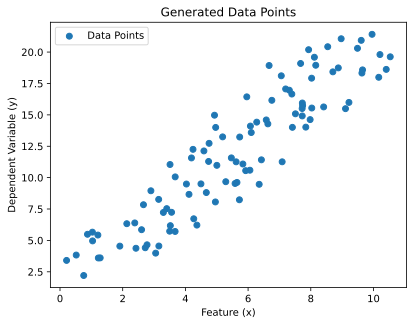

In [ ]:
import matplotlib.pyplot as plt

# Plotting the points formed by A and b
plt.scatter(A[:, 1], b, label='Data Points')
plt.xlabel('Feature (x)')
plt.ylabel('Dependent Variable (y)')
plt.title('Generated Data Points')
plt.legend()
plt.show()

In [ ]:
coef1_values = np.array([])  # Initialize array for coefficient 1
coef2_values = np.array([])  # Initialize array for coefficient 2

def quad_grad(y):
  return np.dot(A.T, (np.dot(A, y) - b))

def soft_thresh(y, t):
  return np.sign(y) * np.maximum(abs(y) - t * mu, 0)

mu_values = np.logspace(2, 0, num=100)
for mu in mu_values:
  x = apg.solve(quad_grad, soft_thresh, np.zeros(n), use_restart=True, eps=1e-12, quiet=True)
  coef1_values = np.append(coef1_values, x[0])
  coef2_values = np.append(coef2_values, x[1])
  print(f"For mu = {mu}, the coefficients are {x}")

For mu = 100.0, the coefficients are [0.        2.0635802]
For mu = 95.45484566618342, the coefficients are [0.         2.06476845]
For mu = 91.11627561154891, the coefficients are [0.         2.06590268]
For mu = 86.97490026177834, the coefficients are [0.         2.06698537]
For mu = 83.02175681319744, the coefficients are [0.         2.06801884]
For mu = 79.24828983539173, the coefficients are [0.         2.06900534]
For mu = 75.64633275546291, the coefficients are [0.         2.06994701]
For mu = 72.20809018385464, the coefficients are [0.         2.07084587]
For mu = 68.92612104349699, the coefficients are [0.         2.07170388]
For mu = 65.79332246575679, the coefficients are [0.         2.07252289]
For mu = 62.80291441834253, the coefficients are [0.         2.07330467]
For mu = 59.94842503189409, the coefficients are [0.         2.07405093]
For mu = 57.22367659350217, the coefficients are [0.         2.07476326]
For mu = 54.62277217684343, the coefficients are [0.         2.07

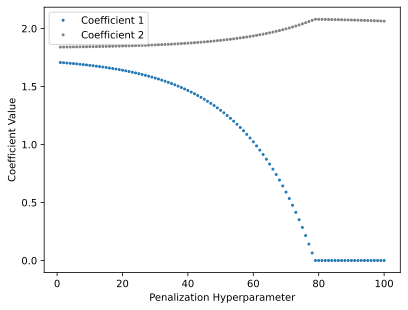

In [ ]:
c

SEE HOW COEFFICIENT GETS SPARSE WHEN WE INCREASE LAMBDA.


*   I apply this Accelerated Proximal Gradient Descent Algorithm on my data


*   This takes 30 minutes






In [ ]:
np_ess_X = np.array(X_trn)

In [ ]:
#num_rows_to_display = 3
#subset_array = np_ess_X[:num_rows_to_display, :]
#print(subset_array)
np_ess_y = np.array(y_trn)

In [ ]:
n = np_ess_X.shape[1]

In [ ]:
for mu_value in range(20, 0, -1):
    mu = mu_value

    def quad_grad(y):
        return np.dot(np_ess_X.T, (np.dot(np_ess_X, y) - np_ess_y))

    def soft_thresh(y, t):
        return np.sign(y) * np.maximum(abs(y) - t * mu, 0)

    x = apg.solve(quad_grad, soft_thresh, np.zeros(n), use_restart=True, eps=1e-12, quiet=True)


    print(f"For mu = {mu}, the coefficients are {x}")

For mu = 20, the coefficients are [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  3.67799190e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -8.32751233e-03  2.54968076e-02 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  5.55170712e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.98133023e-03
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00  3.28173732e-02 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  9.58277443e-04  0.0000

In [ ]:
#keep above untouched

Static accelerated Proximal Gradient descent algorithm for huber loss (With lp normed pernalties).

I simulate a LM model with outliers and then
1.   Fit by OLS
2.   Fit Huber loss (using APGD)





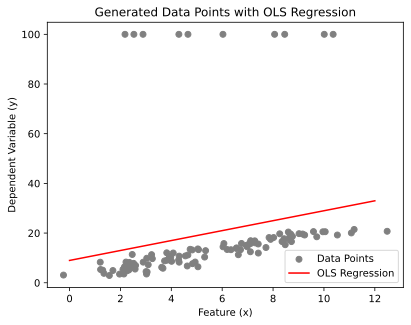

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

n = 2
m = 100

# Generating data
A = np.column_stack((np.ones(m), np.linspace(1, 10, m) + np.random.randn(m)))
b = 2 * np.linspace(1, 10, m) + 1 + 0.5 * np.random.randn(m)

# Introducing outliers
outliers_A = np.column_stack((np.ones(10), np.linspace(1, 10, 10) + np.random.randn(10)))
outliers_b = 100 * np.ones(10)
A = np.vstack([A, outliers_A])
b = np.concatenate([b, outliers_b])

# Computing OLS regression
ols_model = LinearRegression().fit(A, b)
ols_intercept, ols_slope = ols_model.intercept_, ols_model.coef_[1]

# Plotting the points formed by A and b
plt.scatter(A[:, 1], b, label='Data Points', color="grey")

# Plotting OLS regression line
x_vals = np.linspace(0, 12, 100)
y_ols = ols_intercept + ols_slope * x_vals
plt.plot(x_vals, y_ols, label='OLS Regression', color='red')

plt.xlabel('Feature (x)')
plt.ylabel('Dependent Variable (y)')
plt.title('Generated Data Points with OLS Regression')
plt.legend()
plt.show()


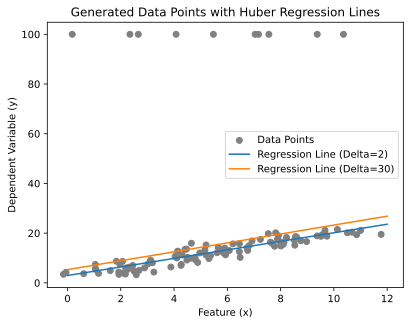

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import apgpy as apg
n = 2
m = 100

A = np.column_stack((np.ones(m), np.linspace(1, 10, m) + np.random.randn(m)))
b = 2 * np.linspace(1, 10, m) + 1 + 0.5 * np.random.randn(m)


outliers_A = np.column_stack((np.ones(10), np.linspace(1, 10, 10) + np.random.randn(10)))
outliers_b = 100 * np.ones(10)
A = np.vstack([A, outliers_A])
b = np.concatenate([b, outliers_b])


plt.scatter(A[:, 1], b, label='Data Points', color="grey")


coef1_values = np.array([])
coef2_values = np.array([])
delta_values = [2, 30]

for delta in delta_values:
    mu = 0  #i.e. MSE ; NO Lnormed Penalizarion

    def huber_loss_gradient(y):
        residual = np.dot(A, y) - b
        huber_grad = np.dot(A.T, np.where(np.abs(residual) <= delta, residual, delta * np.sign(residual)))
        return huber_grad

    def soft_thresh(y, t):
        return np.sign(y) * np.maximum(abs(y) - t * mu, 0)

    x = apg.solve(huber_loss_gradient, soft_thresh, np.zeros(n), use_restart=True, eps=1e-12, quiet=True)
    coef1_values = np.append(coef1_values, x[0])
    coef2_values = np.append(coef2_values, x[1])


    y_reg = x[0] + x[1] * np.linspace(0, 12, 100)
    plt.plot(np.linspace(0, 12, 100), y_reg, label=f'Regression Line (Delta={delta})')

plt.xlabel('Feature (x)')
plt.ylabel('Dependent Variable (y)')
plt.title('Generated Data Points with Huber Regression Lines')
plt.legend()
plt.show()


We see how huber penalty mitigates the effect of outliers.
And we see how the huber loss minimization can be done by using the accelerated proximal gradient descent method.
(By changing the mu values , you can test for lasso + huber)


**Static Accelerated Proximal Gradient descent for Elastic Net penalization.**

In [ ]:
n = 2
m = 100
A = np.column_stack((np.ones(m), np.linspace(1, 10, m) + np.random.randn(m)))
b = 2 * np.linspace(1, 10, m) + 1 + 0.5 * np.random.randn(m)

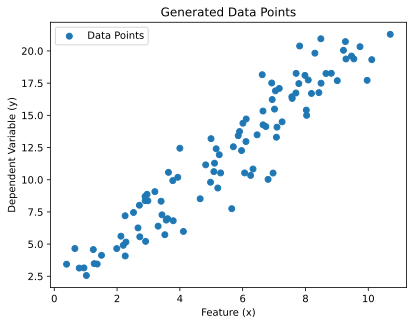

In [ ]:
# Plotting the points formed by A and b
plt.scatter(A[:, 1], b, label='Data Points')
plt.xlabel('Feature (x)')
plt.ylabel('Dependent Variable (y)')
plt.title('Generated Data Points')
plt.legend()
plt.show()

In [ ]:
coef1_values_en = np.array([])  # Initialize array for coefficient 1
coef2_values_en = np.array([])  # Initialize array for coefficient 2

rho = 0.1
for mu_value in range(100, 0, -1):
    mu = mu_value

    def quad_grad(y):
        return np.dot(A.T, (np.dot(A, y) - b))

    def elastic_net_proximal_operator(y, t):
      soft_thresh_term = np.sign(y) * np.maximum(np.abs(y) - t * mu * (1 - rho), 0)
      return soft_thresh_term / (1 + t * rho * mu)


    x_en = apg.solve(quad_grad, elastic_net_proximal_operator, np.zeros(n), use_restart=True, eps=1e-12, quiet=True)
    coef1_values_en = np.append(coef1_values_en, x_en[0])
    coef2_values_en = np.append(coef2_values_en, x_en[1])

    print(f"For mu = {mu}, the coefficients are {x_en}")

For mu = 100, the coefficients are [0.         2.10068028]
For mu = 99, the coefficients are [0.         2.10097989]
For mu = 98, the coefficients are [0.         2.10127951]
For mu = 97, the coefficients are [0.         2.10157914]
For mu = 96, the coefficients are [0.        2.1018788]
For mu = 95, the coefficients are [0.         2.10217847]
For mu = 94, the coefficients are [0.         2.10247815]
For mu = 93, the coefficients are [0.         2.10277785]
For mu = 92, the coefficients are [0.         2.10307757]
For mu = 91, the coefficients are [0.        2.1033773]
For mu = 90, the coefficients are [0.         2.10367705]
For mu = 89, the coefficients are [0.         2.10397682]
For mu = 88, the coefficients are [0.        2.1042766]
For mu = 87, the coefficients are [0.        2.1045764]
For mu = 86, the coefficients are [0.         2.10487622]
For mu = 85, the coefficients are [0.         2.10517605]
For mu = 84, the coefficients are [0.         2.10547589]
For mu = 83, the coef

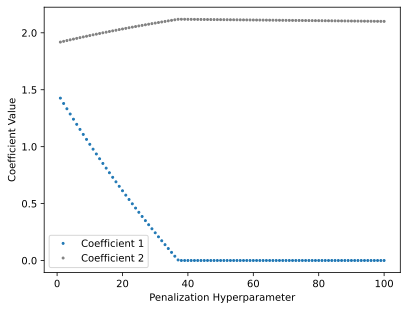

In [ ]:
mu_values = np.arange(100, 0, -1)
plt.plot(mu_values, coef1_values_en , 'o', label='Coefficient 1',markersize = 2 )
plt.plot(mu_values, coef2_values_en , 'o', label='Coefficient 2', markersize = 2, color = "grey")
plt.xlabel('Penalization Hyperparameter')
plt.ylabel('Coefficient Value')
plt.legend()
plt.show()

**Elastic Net Induces sparsity**
A low Rho and large lambda ( here called mu) will encourage sparsity as they increase penalty on L1
**See EN penalty formula**

**I apply Accelerated Proximal Gradient Descent to find:**

1.   Lasso with squared loss
2.   Lasso with Huber loss
3.   Elastic Net with squared loss
4.   Elastic Net with huber loss


In [ ]:
#lets go

In [ ]:
class LassoMse:

    def __init__(self, mu=1):
      self.mu = mu

    def set_params(self, **params):
        for param in params.keys():
            setattr(self, param, params[param])
        return self


    def fit(self, X, y):
      X = np.array(X)
      n = X.shape[1]
      y = np.array(y)
      def quad_grad(beta):
        return np.dot(X.T, (np.dot(X, beta) - y))

      def soft_thresh(beta, t):
        return np.sign(beta) * np.maximum(abs(beta) - t * self.mu, 0)

      coef_lasso_mse = apg.solve(quad_grad, soft_thresh, np.zeros(n), use_restart=True, eps=1e-12, quiet=True)
      self.coef = coef_lasso_mse
      return self


    def predict(self, X):
        return np.dot(X, self.coef)

I define a set of 10 log scaled range from e^-3 to 20 lambda values.
I cannot rely on a bigger set. This set alone takes approx 20 min without validation.

In [ ]:
params = {'mu': np.logspace(np.log10(0.001), np.log10(20), 10).tolist()}

In [ ]:
lasso_mse = val_fun(LassoMse,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld,sleep=3)

Model with params: {'mu': 0.001} finished.
with out-of-sample MSE on validation set: 0.01732
with out-of-sample R-squared on validation set: -73.1669021%
************************************************************
Model with params: {'mu': 0.0030053303814001576} finished.
with out-of-sample MSE on validation set: 0.01580
with out-of-sample R-squared on validation set: -53.6711880%
************************************************************
Model with params: {'mu': 0.009032010701366826} finished.
with out-of-sample MSE on validation set: 0.01514
with out-of-sample R-squared on validation set: -45.0754208%
************************************************************
Model with params: {'mu': 0.027144176165949066} finished.
with out-of-sample MSE on validation set: 0.01475
with out-of-sample R-squared on validation set: -39.9710361%
************************************************************
Model with params: {'mu': 0.08157721730960482} finished.
with out-of-sample MSE on validation 

This suggests that a higher penalization tuning rate might be better
I repeat with another higher range

In [ ]:
params = {'mu': np.logspace(np.log10(20), np.log10(900),10).tolist()}

In [ ]:
lasso_mse = val_fun(LassoMse,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld,sleep=3)

Model with params: {'mu': 20.000000000000004} finished.
with out-of-sample MSE on validation set: 0.01014
with out-of-sample R-squared on validation set: -2.5841939%
************************************************************
Model with params: {'mu': 30.529541005372952} finished.
with out-of-sample MSE on validation set: 0.00997
with out-of-sample R-squared on validation set: 2.4622923%
************************************************************
Model with params: {'mu': 46.60264369993742} finished.
with out-of-sample MSE on validation set: 0.01008
with out-of-sample R-squared on validation set: 1.7540674%
************************************************************
Model with params: {'mu': 71.13786608980126} finished.
with out-of-sample MSE on validation set: 0.00984
with out-of-sample R-squared on validation set: 1.4821687%
************************************************************
Model with params: {'mu': 108.59031999116581} finished.
with out-of-sample MSE on validation set:

/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'mu': 589.5928797891899} finished.
with out-of-sample MSE on validation set: 0.00869
with out-of-sample R-squared on validation set: 0.7956275%
************************************************************
Model with params: {'mu': 899.9999999999998} finished.
with out-of-sample MSE on validation set: 0.00876
with out-of-sample R-squared on validation set: 0.0000000%
************************************************************

############################################################
Tuning process finished!!!
The best setting is: {'mu': 386.2441821090113}
with MSE OOS 0.00865 on validation set.
############################################################


I evaluate

In [ ]:
params = {'mu': [386.2441821090113]}
LassoMse = val_fun(LassoMse,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld,sleep=3)
evaluate(y_tst, LassoMse.predict(X_tst))

Model with params: {'mu': 386.2441821090113} finished.
with out-of-sample MSE on validation set: 0.00865
with out-of-sample R-squared on validation set: 1.2919810%
************************************************************

############################################################
Tuning process finished!!!
The best setting is: {'mu': 386.2441821090113}
with MSE OOS 0.00865 on validation set.
############################################################
***************Out-of-Sample Metrics***************
The out-of-sample R2 is 0.99509%
The out-of-sample MSE is 0.00858677


oos mse is 0.0085
Now I test huber loss on lasso

In [ ]:
class LassoHuber:

    def __init__(self, mu=1, delta = 1):
      self.mu = mu
      self.delta = delta

    def set_params(self, **params):
        for param in params.keys():
            setattr(self, param, params[param])
        return self


    def fit(self, X, y):
      X = np.array(X)
      n = X.shape[1]
      y = np.array(y)

      def huber_loss_gradient(beta):
        residual = np.dot(X, beta) - y
        huber_grad = np.dot(X.T, np.where(np.abs(residual) <= self.delta, residual, self.delta * np.sign(residual)))
        return huber_grad

      def soft_thresh(beta, t):
        return np.sign(beta) * np.maximum(abs(beta) - t * self.mu, 0)


      coef_lasso_huber = apg.solve(huber_loss_gradient, soft_thresh, np.zeros(n), use_restart=True, eps=1e-12, quiet=True)
      self.coef = coef_lasso_huber
      return self


    def predict(self, X):
        return np.dot(X, self.coef)

In [ ]:
params = {'mu': np.linspace(10,800,5).tolist(),'delta':[0.025]}

In [ ]:
print(params)

{'mu': [10.0, 207.5, 405.0, 602.5, 800.0], 'delta': [0.025]}


In [ ]:
lassoHuber = val_fun(LassoHuber,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld,sleep=3)

/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.025, 'mu': 10.0} finished.
with out-of-sample MSE on validation set: 0.00958
with out-of-sample R-squared on validation set: 2.6224109%
************************************************************
Model with params: {'delta': 0.025, 'mu': 207.5} finished.
with out-of-sample MSE on validation set: 0.00871
with out-of-sample R-squared on validation set: 0.4734713%
************************************************************
Model with params: {'delta': 0.025, 'mu': 405.0} finished.
with out-of-sample MSE on validation set: 0.00876
with out-of-sample R-squared on validation set: 0.0000000%
************************************************************
Model with params: {'delta': 0.025, 'mu': 602.5} finished.
with out-of-sample MSE on validation set: 0.00876
with out-of-sample R-squared on validation set: 0.0000000%
************************************************************
Model with params: {'delta': 0.025, 'mu': 800.0} finished.
with out-of-sample MSE on 

In [ ]:
evaluate(y_tst, lassoHuber.predict(X_tst))

***************Out-of-Sample Metrics***************
The out-of-sample R2 is 0.36282%
The out-of-sample MSE is 0.00864447


Last trial on lasso - Previous Results suggest that a good hyperparameter could be retreived between 200 and 400

In [ ]:
params = {'mu': np.linspace(250,390,10).tolist(),'delta':[0.025]}
lassoHuber = val_fun(LassoHuber,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld,sleep=3)
evaluate(y_tst, lassoHuber.predict(X_tst))

Model with params: {'delta': 0.025, 'mu': 250.0} finished.
with out-of-sample MSE on validation set: 0.00876
with out-of-sample R-squared on validation set: 0.0000000%
************************************************************
Model with params: {'delta': 0.025, 'mu': 265.55555555555554} finished.
with out-of-sample MSE on validation set: 0.00876
with out-of-sample R-squared on validation set: 0.0000000%
************************************************************
Model with params: {'delta': 0.025, 'mu': 281.1111111111111} finished.
with out-of-sample MSE on validation set: 0.00876
with out-of-sample R-squared on validation set: 0.0000000%
************************************************************
Model with params: {'delta': 0.025, 'mu': 296.6666666666667} finished.
with out-of-sample MSE on validation set: 0.00876
with out-of-sample R-squared on validation set: 0.0000000%
************************************************************
Model with params: {'delta': 0.025, 'mu': 312.2

Now; **Elastic Net using MSE loss function**

In [ ]:
class ElasticNetMse:

    def __init__(self, mu=1, rho = 0.1):   #birmania
      self.mu = mu
      self.rho = rho

    def set_params(self, **params):
        for param in params.keys():
            setattr(self, param, params[param])
        return self


    def fit(self, X, y):
      X = np.array(X)
      n = X.shape[1]
      y = np.array(y)

      def quad_grad(beta):
        return np.dot(X.T, (np.dot(X, beta) - y))

      def elastic_net_proximal_operator(beta, t):
        soft_thresh_term = np.sign(beta) * np.maximum(np.abs(beta) - t * self.mu * (1 - self.rho), 0)
        return soft_thresh_term / (1 + t * self.rho * self.mu)

      coef_en_mse = apg.solve(quad_grad, elastic_net_proximal_operator, np.zeros(n), use_restart=True, eps=1e-12, quiet=True)
      self.coef = coef_en_mse

      return self



    def predict(self, X):
        return np.dot(X, self.coef)

Low rho and Large mu will encourage sparisty ; I thus chose the following sets for mu and rho

In [ ]:
params = {'mu': np.logspace(np.log10(50), np.log10(900), 7).tolist(),'rho':[0.1]}

In [ ]:
ElasticNetMse = val_fun(ElasticNetMse,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld,sleep=3)
evaluate(y_tst, ElasticNetMse.predict(X_tst))

Model with params: {'mu': 49.99999999999999, 'rho': 0.1} finished.
with out-of-sample MSE on validation set: 0.01008
with out-of-sample R-squared on validation set: 1.8071351%
************************************************************
Model with params: {'mu': 80.94352034302831, 'rho': 0.1} finished.
with out-of-sample MSE on validation set: 0.00982
with out-of-sample R-squared on validation set: 1.4645238%
************************************************************
Model with params: {'mu': 131.03706971044477, 'rho': 0.1} finished.
with out-of-sample MSE on validation set: 0.00945
with out-of-sample R-squared on validation set: 1.2323305%
************************************************************
Model with params: {'mu': 212.13203435596432, 'rho': 0.1} finished.
with out-of-sample MSE on validation set: 0.00897
with out-of-sample R-squared on validation set: 1.3430272%
************************************************************
Model with params: {'mu': 343.4142727659996, 'rho'

In [ ]:
class ElasticNetHuber:

    def __init__(self, mu=1, rho = 0.1,delta =0.02 ):   #birmania
      self.mu = mu
      self.delta = delta
      self.rho = rho

    def set_params(self, **params):
        for param in params.keys():
            setattr(self, param, params[param])
        return self


    def fit(self, X, y):
      X = np.array(X)
      n = X.shape[1]
      y = np.array(y)

      def huber_loss_gradient(beta):
        residual = np.dot(X, beta) - y
        huber_grad = np.dot(X.T, np.where(np.abs(residual) <= self.delta, residual, self.delta * np.sign(residual)))
        return huber_grad

      def elastic_net_proximal_operator(beta, t):
        soft_thresh_term = np.sign(beta) * np.maximum(np.abs(beta) - t * self.mu * (1 - self.rho), 0)
        return soft_thresh_term / (1 + t * self.rho * self.mu)

      coef_en_huber = apg.solve(huber_loss_gradient, elastic_net_proximal_operator, np.zeros(n), use_restart=True, eps=1e-12, quiet=True)
      self.coef = coef_en_huber

      return self



    def predict(self, X):
        return np.dot(X, self.coef)

**GOOD !!! DO NOT TOUCH !!! TAKES 30 MIN**

In [ ]:
params = {'mu': np.logspace(np.log10(20), np.log10(500), 10).tolist(),'delta':np.array([0.02, 0.03, 0.05, 0.1]),'rho':[0.1]}

In [ ]:
ElasticNetHuber= val_fun(ElasticNetHuber,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld,sleep=3)   #douala #need to run

/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.02, 'mu': 20.000000000000004, 'rho': 0.1} finished.
with out-of-sample MSE on validation set: 0.00901
with out-of-sample R-squared on validation set: 2.1952860%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.02, 'mu': 28.59938296617457, 'rho': 0.1} finished.
with out-of-sample MSE on validation set: 0.00876
with out-of-sample R-squared on validation set: 1.8126687%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.02, 'mu': 40.89623530229583, 'rho': 0.1} finished.
with out-of-sample MSE on validation set: 0.00859
with out-of-sample R-squared on validation set: 1.9645219%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.02, 'mu': 58.48035476425734, 'rho': 0.1} finished.
with out-of-sample MSE on validation set: 0.00858
with out-of-sample R-squared on validation set: 2.1127263%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.02, 'mu': 83.62510309503736, 'rho': 0.1} finished.
with out-of-sample MSE on validation set: 0.00860
with out-of-sample R-squared on validation set: 1.8623849%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.02, 'mu': 119.58131745004017, 'rho': 0.1} finished.
with out-of-sample MSE on validation set: 0.00863
with out-of-sample R-squared on validation set: 1.4249387%
************************************************************
Model with params: {'delta': 0.02, 'mu': 170.9975946676698, 'rho': 0.1} finished.
with out-of-sample MSE on validation set: 0.00869
with out-of-sample R-squared on validation set: 0.7189589%
************************************************************
Model with params: {'delta': 0.02, 'mu': 244.52128480976896, 'rho': 0.1} finished.
with out-of-sample MSE on validation set: 0.00876
with out-of-sample R-squared on validation set: 0.0000000%
************************************************************
Model with params: {'delta': 0.02, 'mu': 349.6578933827813, 'rho': 0.1} finished.
with out-of-sample MSE on validation set: 0.00876
with out-of-sample R-squared on validation set: 0.0000000%
***************************************************

/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.03, 'mu': 20.000000000000004, 'rho': 0.1} finished.
with out-of-sample MSE on validation set: 0.00936
with out-of-sample R-squared on validation set: 2.4001083%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.03, 'mu': 28.59938296617457, 'rho': 0.1} finished.
with out-of-sample MSE on validation set: 0.00906
with out-of-sample R-squared on validation set: 2.1661079%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.03, 'mu': 40.89623530229583, 'rho': 0.1} finished.
with out-of-sample MSE on validation set: 0.00880
with out-of-sample R-squared on validation set: 1.7564501%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.03, 'mu': 58.48035476425734, 'rho': 0.1} finished.
with out-of-sample MSE on validation set: 0.00860
with out-of-sample R-squared on validation set: 1.9404412%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.03, 'mu': 83.62510309503736, 'rho': 0.1} finished.
with out-of-sample MSE on validation set: 0.00858
with out-of-sample R-squared on validation set: 2.0960510%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.03, 'mu': 119.58131745004017, 'rho': 0.1} finished.
with out-of-sample MSE on validation set: 0.00860
with out-of-sample R-squared on validation set: 1.8774051%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.03, 'mu': 170.9975946676698, 'rho': 0.1} finished.
with out-of-sample MSE on validation set: 0.00863
with out-of-sample R-squared on validation set: 1.4469707%
************************************************************
Model with params: {'delta': 0.03, 'mu': 244.52128480976896, 'rho': 0.1} finished.
with out-of-sample MSE on validation set: 0.00869
with out-of-sample R-squared on validation set: 0.7542106%
************************************************************
Model with params: {'delta': 0.03, 'mu': 349.6578933827813, 'rho': 0.1} finished.
with out-of-sample MSE on validation set: 0.00876
with out-of-sample R-squared on validation set: 0.0000000%
************************************************************
Model with params: {'delta': 0.03, 'mu': 499.99999999999994, 'rho': 0.1} finished.
with out-of-sample MSE on validation set: 0.00876
with out-of-sample R-squared on validation set: 0.0000000%
***************************************************

/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.05, 'mu': 20.000000000000004, 'rho': 0.1} finished.
with out-of-sample MSE on validation set: 0.00968
with out-of-sample R-squared on validation set: 2.4144521%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.05, 'mu': 28.59938296617457, 'rho': 0.1} finished.
with out-of-sample MSE on validation set: 0.00951
with out-of-sample R-squared on validation set: 2.2238241%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.05, 'mu': 40.89623530229583, 'rho': 0.1} finished.
with out-of-sample MSE on validation set: 0.00920
with out-of-sample R-squared on validation set: 2.1458944%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.05, 'mu': 58.48035476425734, 'rho': 0.1} finished.
with out-of-sample MSE on validation set: 0.00894
with out-of-sample R-squared on validation set: 1.6480374%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.05, 'mu': 83.62510309503736, 'rho': 0.1} finished.
with out-of-sample MSE on validation set: 0.00863
with out-of-sample R-squared on validation set: 1.8834269%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.05, 'mu': 119.58131745004017, 'rho': 0.1} finished.
with out-of-sample MSE on validation set: 0.00859
with out-of-sample R-squared on validation set: 2.0303257%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.05, 'mu': 170.9975946676698, 'rho': 0.1} finished.
with out-of-sample MSE on validation set: 0.00859
with out-of-sample R-squared on validation set: 1.9300477%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.05, 'mu': 244.52128480976896, 'rho': 0.1} finished.
with out-of-sample MSE on validation set: 0.00862
with out-of-sample R-squared on validation set: 1.5348054%
************************************************************
Model with params: {'delta': 0.05, 'mu': 349.6578933827813, 'rho': 0.1} finished.
with out-of-sample MSE on validation set: 0.00868
with out-of-sample R-squared on validation set: 0.9023645%
************************************************************
Model with params: {'delta': 0.05, 'mu': 499.99999999999994, 'rho': 0.1} finished.
with out-of-sample MSE on validation set: 0.00876
with out-of-sample R-squared on validation set: 0.0000000%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.1, 'mu': 20.000000000000004, 'rho': 0.1} finished.
with out-of-sample MSE on validation set: 0.00974
with out-of-sample R-squared on validation set: 2.5009065%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.1, 'mu': 28.59938296617457, 'rho': 0.1} finished.
with out-of-sample MSE on validation set: 0.00982
with out-of-sample R-squared on validation set: 2.4937055%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.1, 'mu': 40.89623530229583, 'rho': 0.1} finished.
with out-of-sample MSE on validation set: 0.00981
with out-of-sample R-squared on validation set: 1.7725680%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.1, 'mu': 58.48035476425734, 'rho': 0.1} finished.
with out-of-sample MSE on validation set: 0.00951
with out-of-sample R-squared on validation set: 1.7928447%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.1, 'mu': 83.62510309503736, 'rho': 0.1} finished.
with out-of-sample MSE on validation set: 0.00922
with out-of-sample R-squared on validation set: 1.4793919%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.1, 'mu': 119.58131745004017, 'rho': 0.1} finished.
with out-of-sample MSE on validation set: 0.00884
with out-of-sample R-squared on validation set: 1.5827436%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.1, 'mu': 170.9975946676698, 'rho': 0.1} finished.
with out-of-sample MSE on validation set: 0.00861
with out-of-sample R-squared on validation set: 1.7651698%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.1, 'mu': 244.52128480976896, 'rho': 0.1} finished.
with out-of-sample MSE on validation set: 0.00860
with out-of-sample R-squared on validation set: 1.8546066%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.1, 'mu': 349.6578933827813, 'rho': 0.1} finished.
with out-of-sample MSE on validation set: 0.00862
with out-of-sample R-squared on validation set: 1.5317903%
************************************************************
Model with params: {'delta': 0.1, 'mu': 499.99999999999994, 'rho': 0.1} finished.
with out-of-sample MSE on validation set: 0.00867
with out-of-sample R-squared on validation set: 0.9396194%
************************************************************

############################################################
Tuning process finished!!!
The best setting is: {'delta': 0.02, 'mu': 58.48035476425734, 'rho': 0.1}
with MSE OOS 0.00858 on validation set.
############################################################


**DO NOT TOUCH ABOVE!!!**  ############################################################
Tuning process finished!!!
The best setting is: {'delta': 0.02, 'mu': 58.48035476425734, 'rho': 0.1}
with MSE OOS 0.00858 on validation set.
############################################################

In [ ]:
params = {'mu': np.linspace(60, 800, 5).tolist(),'delta':[0.025],'rho':[0.1]}

In [ ]:
ElasticNetHuber= val_fun(ElasticNetHuber,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld,sleep=3)
evaluate(y_tst, ElasticNetHuber.predict(X_tst))

/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.025, 'mu': 60.0, 'rho': 0.1} finished.
with out-of-sample MSE on validation set: 0.00858
with out-of-sample R-squared on validation set: 2.0608403%
************************************************************
Model with params: {'delta': 0.025, 'mu': 245.0, 'rho': 0.1} finished.
with out-of-sample MSE on validation set: 0.00873
with out-of-sample R-squared on validation set: 0.2909634%
************************************************************
Model with params: {'delta': 0.025, 'mu': 430.0, 'rho': 0.1} finished.
with out-of-sample MSE on validation set: 0.00876
with out-of-sample R-squared on validation set: 0.0000000%
************************************************************
Model with params: {'delta': 0.025, 'mu': 615.0, 'rho': 0.1} finished.
with out-of-sample MSE on validation set: 0.00876
with out-of-sample R-squared on validation set: 0.0000000%
************************************************************
Model with params: {'delta': 0.025, '

**STILL NEED TO TEST OUF OF SAMPLE THIS METHOD . EVALUATE ALONG WITH OTHER ....**

ridge & evaluate all previous


**TREES**

*   I show how trees are equivalent to partitionning the feature space and to fitting a piecewise constant function
*  This is done for illustrative purposes only



In [ ]:
X_train_macro = X_trn[['ep']]
X_test_macro = X_vld[['ep']]

In [ ]:
combined_df = pd.concat([X_train_macro, X_test_macro], ignore_index=True)
combined_y =  pd.concat([y_trn, y_vld], ignore_index=True)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


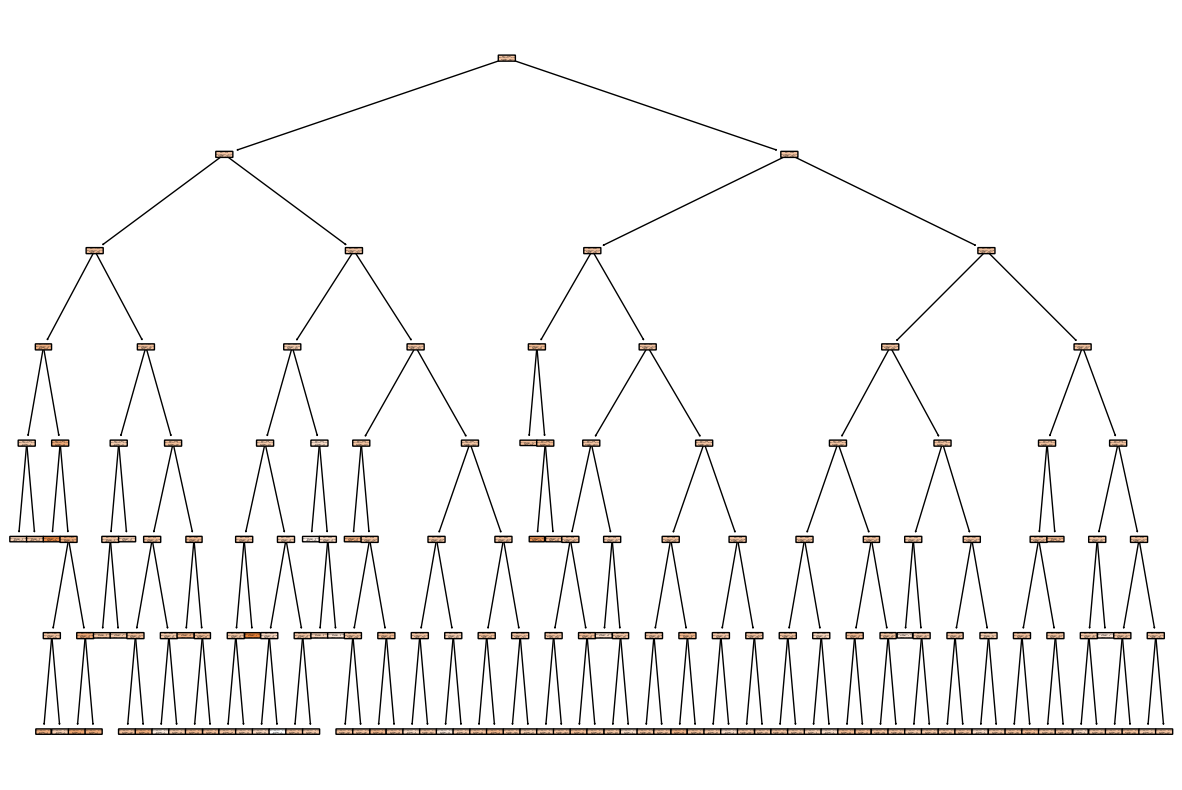

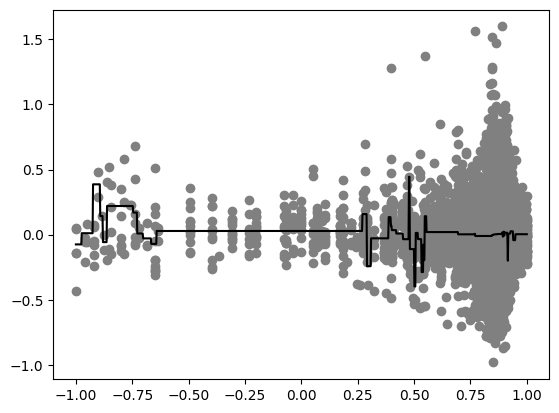

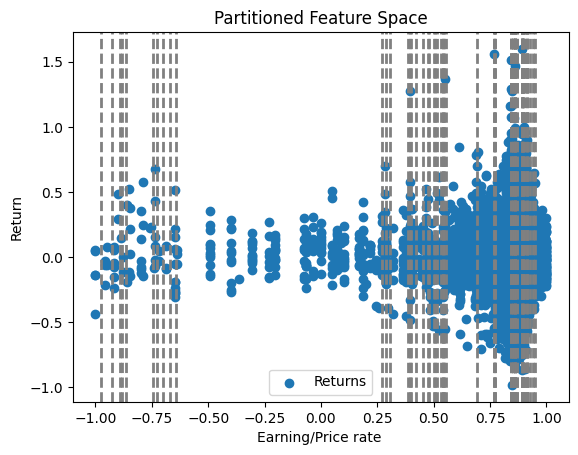

Mean Squared Error on test data: 0.008963609722164017


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split


reg_tree = DecisionTreeRegressor( max_depth=7)
reg_tree.fit(X_train_macro, y_trn)

plt.figure(figsize=(15, 10))

# Plot the data points
plt.scatter(combined_df, combined_y, label='Returns')



plot_tree(reg_tree, filled=True, rounded=True, feature_names=X_train_macro.columns)

plt.savefig('regression_tree_plot.svg', format='svg', bbox_inches='tight')

# Plot the piecewise constant function represented by the regression tree
plt.figure()
X_range = np.linspace(combined_df.min(), combined_df.max(), 1000).reshape(-1, 1)
y_pred = reg_tree.predict(X_range)

plt.scatter(combined_df, combined_y, label='Data Points', color='grey')
plt.plot(X_range, y_pred, color='black', label='Piecewise Constant Function')

# Save the plot as an SVG file
plt.savefig('piecewise_constant_function_plot.svg', format='svg', bbox_inches='tight')

# Plot the partitioned feature space
plt.figure()
plt.scatter(combined_df, combined_y, label='Returns')

# Plot the partitioned feature space
for split_value in reg_tree.tree_.threshold[reg_tree.tree_.threshold != -2]:
    plt.axvline(x=split_value, color='gray', linestyle='--', linewidth=2)

plt.title('Partitioned Feature Space')
plt.xlabel('Earning/Price rate ')
plt.ylabel('Return')
plt.legend()

# Save the plot as an SVG file
plt.savefig('partitioned_feature_space_plot.svg', format='svg', bbox_inches='tight')

# Show the plots
plt.show()

# Evaluate the model
mse = np.mean((reg_tree.predict(X_test_macro) - y_vld) ** 2)
print(f"Mean Squared Error on test data: {mse}")


Now
let's build a Regression **Tree with cost complexity pruning regularization **

**Regression tree with pruning**

In [ ]:
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor, export_text, plot_tree
import matplotlib.pyplot as plt

In [ ]:
class RegressionTree:
    def __init__(self, ccp_alpha=1e-06):
        self.ccp_alpha = ccp_alpha
        self.reg_tree = DecisionTreeRegressor(ccp_alpha=self.ccp_alpha)

    def set_params(self, **params):
        for param in params.keys():
            setattr(self, param, params[param])
        return self

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        self.reg_tree.fit(X, y)
        return self

    def predict(self, X):
        return self.reg_tree.predict(X)



In [ ]:
params = {'ccp_alpha': np.logspace(np.log10(1e-06), np.log10(1e-01), 5).tolist()}

In [ ]:
print(params)

{'ccp_alpha': [1e-06, 1.778279410038923e-05, 0.00031622776601683794, 0.005623413251903491, 0.1]}


In [ ]:
RegressionTree= val_fun(RegressionTree,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld,sleep=3)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


Model with params: {'ccp_alpha': 1e-06} finished.
with out-of-sample MSE on validation set: 0.04640
with out-of-sample R-squared on validation set: -127.8188813%
************************************************************


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


Model with params: {'ccp_alpha': 1.778279410038923e-05} finished.
with out-of-sample MSE on validation set: 0.04377
with out-of-sample R-squared on validation set: -143.1835427%
************************************************************


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


Model with params: {'ccp_alpha': 0.00031622776601683794} finished.
with out-of-sample MSE on validation set: 0.05064
with out-of-sample R-squared on validation set: -168.2429768%
************************************************************


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


Model with params: {'ccp_alpha': 0.005623413251903491} finished.
with out-of-sample MSE on validation set: 0.04802
with out-of-sample R-squared on validation set: -156.0257838%
************************************************************
Model with params: {'ccp_alpha': 0.1} finished.
with out-of-sample MSE on validation set: 0.05395
with out-of-sample R-squared on validation set: -254.6555604%
************************************************************

############################################################
Tuning process finished!!!
The best setting is: {'ccp_alpha': 1.778279410038923e-05}
with MSE OOS 0.04377 on validation set.
############################################################


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


In [ ]:
params = {'ccp_alpha': [1e-10,1e-8]}
RegressionTree= val_fun(RegressionTree,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld,sleep=3)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


Model with params: {'ccp_alpha': 1e-10} finished.
with out-of-sample MSE on validation set: 0.05538
with out-of-sample R-squared on validation set: -273.7674484%
************************************************************
Model with params: {'ccp_alpha': 1e-08} finished.
with out-of-sample MSE on validation set: 0.05549
with out-of-sample R-squared on validation set: -264.3033912%
************************************************************

############################################################
Tuning process finished!!!
The best setting is: {'ccp_alpha': 1e-10}
with MSE OOS 0.05538 on validation set.
############################################################


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


Bagging and boosting


Starting with boosting

In [ ]:
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [ ]:
class BoostedMse:

    def __init__(self, learning_rate=0.1, n_estimators=50, max_depth=1):
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.max_depth = max_depth


    def set_params(self, **params):
        for param in params.keys():
            setattr(self, param, params[param])
        return self

    def fit(self, X, y):
        self.model = GradientBoostingRegressor(learning_rate=self.learning_rate, n_estimators=self.n_estimators, max_depth=self.max_depth)
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)


In [ ]:
params = {'ccp_alpha': [0.1,0.2,0.3], 'n_estimators' : [ 50 , 100 , 200] , 'max_depth' :[ 1] }

There is a typo here ccp_alpha is actually the learning rate; I will not fix it as the subsequent code takes 3 hours to run

In [ ]:
BoostedMse= val_fun(BoostedMse,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld,sleep=3)

Model with params: {'ccp_alpha': 0.1, 'max_depth': 1, 'n_estimators': 50} finished.
with out-of-sample MSE on validation set: 0.00932
with out-of-sample R-squared on validation set: 2.2164233%
************************************************************
Model with params: {'ccp_alpha': 0.1, 'max_depth': 1, 'n_estimators': 100} finished.
with out-of-sample MSE on validation set: 0.00954
with out-of-sample R-squared on validation set: 2.5364935%
************************************************************
Model with params: {'ccp_alpha': 0.1, 'max_depth': 1, 'n_estimators': 200} finished.
with out-of-sample MSE on validation set: 0.01106
with out-of-sample R-squared on validation set: 1.8840281%
************************************************************
Model with params: {'ccp_alpha': 0.2, 'max_depth': 1, 'n_estimators': 50} finished.
with out-of-sample MSE on validation set: 0.00932
with out-of-sample R-squared on validation set: 2.2164233%
*******************************************

more - Boosted

In [ ]:
params = {'ccp_alpha': [0.01], 'n_estimators' : [ 500 , 1000 ] , 'max_depth' :[1,2] }
BoostedMse= val_fun(BoostedMse,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld,sleep=3)
evaluate(y_tst, BoostedMse.predict(X_tst))

Model with params: {'ccp_alpha': 0.01, 'max_depth': 1, 'n_estimators': 500} finished.
with out-of-sample MSE on validation set: 0.01294
with out-of-sample R-squared on validation set: 1.2535847%
************************************************************


Boosting using GradientBoostingRegressor is too expensive computationally for the parameters below

In [ ]:
#params = {'ccp_alpha': [0.01], 'n_estimators' : [ 500 , 1000 ] , 'max_depth' :[7] }
#BoostedMse= val_fun(BoostedMse,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld,sleep=3)

I will use xgboost instead

In [ ]:
from xgboost import XGBRegressor

params = {
    'n_estimators': [500,1000],
    'max_depth': [7],
    'random_state': [12308],
    'learning_rate': [.01]
}
XGB = val_fun(XGBRegressor,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld)

Model with params: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 500, 'random_state': 12308} finished.
with out-of-sample MSE on validation set: 0.01220
with out-of-sample R-squared on validation set: -11.1331161%
************************************************************
Model with params: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 1000, 'random_state': 12308} finished.
with out-of-sample MSE on validation set: 0.01299
with out-of-sample R-squared on validation set: -12.8700309%
************************************************************

############################################################
Tuning process finished!!!
The best setting is: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 500, 'random_state': 12308}
with MSE OOS 0.01220 on validation set.
############################################################


In [ ]:
from xgboost import XGBRegressor

params = {
    'n_estimators': [1000],
    'max_depth': [10],
    'random_state': [12308],
    'learning_rate': [.1]
}
XGB = val_fun(XGBRegressor,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld)

Model with params: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1000, 'random_state': 12308} finished.
with out-of-sample MSE on validation set: 0.01490
with out-of-sample R-squared on validation set: -30.4917693%
************************************************************

############################################################
Tuning process finished!!!
The best setting is: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1000, 'random_state': 12308}
with MSE OOS 0.01490 on validation set.
############################################################


**Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
class RandomForest:

    def __init__(self,   n_estimators=50 , max_depth=2 , max_features = 20 ):

        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features= max_features

    def set_params(self, **params):
        for param in params.keys():
            setattr(self, param, params[param])
        return self

    def fit(self, X, y):
        self.model = RandomForestRegressor(n_estimators=self.n_estimators, max_depth=self.max_depth)
        return self

    def predict(self, X):
        self.max_depth, max_features=self.max_features)
        self.model.fit(X, y)
        return self.model.predict(X)

params = {'n_estimators': [300,400], 'max_depth' : [ 5 , 6 , 7] , 'max_features' :[30,50,100] }

In [ ]:
RandomForest= val_fun(RandomForest,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld,sleep=3)
evaluate(y_tst, RandomForest.predict(X_tst))

Model with params: {'max_depth': 5, 'max_features': 30, 'n_estimators': 300} finished.
with out-of-sample MSE on validation set: 0.01030
with out-of-sample R-squared on validation set: 0.2626629%
************************************************************
Model with params: {'max_depth': 5, 'max_features': 30, 'n_estimators': 400} finished.
with out-of-sample MSE on validation set: 0.01044
with out-of-sample R-squared on validation set: 0.0449271%
************************************************************
Model with params: {'max_depth': 5, 'max_features': 50, 'n_estimators': 300} finished.
with out-of-sample MSE on validation set: 0.00972
with out-of-sample R-squared on validation set: 0.9986348%
************************************************************
Model with params: {'max_depth': 5, 'max_features': 50, 'n_estimators': 400} finished.
with out-of-sample MSE on validation set: 0.00988
with out-of-sample R-squared on validation set: 0.3953293%
*********************************

**RIDGE**


*   I use Accelerated Proximal Gradient descent - the proximal operator of ridge penalty in defined in appendix
*   See Ridge's regularization path using simulated data
*   I then construct apply ridge on the dataset



In [ ]:
import apgpy as apg
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

n = 2
m = 100
A = np.column_stack((np.ones(m), np.linspace(1, 10, m) + np.random.randn(m)))
b = 2 * np.linspace(1, 10, m) + 1 + 0.5 * np.random.randn(m)
import matplotlib.pyplot as plt





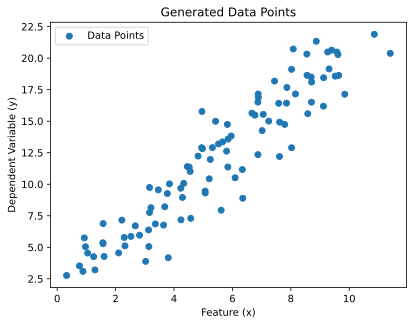

In [ ]:

# Plotting the points formed by A and b
plt.scatter(A[:, 1], b, label='Data Points')
plt.xlabel('Feature (x)')
plt.ylabel('Dependent Variable (y)')
plt.title('Generated Data Points')
plt.legend()
plt.show()
coef1_values_rid = np.array([])  # Initialize array for coefficient 1
coef2_values_rid = np.array([])  # Initialize array for coefficient 2



In [ ]:
mu_values = np.arange(200, 0, -1)

def quad_grad(y):
  return np.dot(A.T, (np.dot(A, y) - b))

def prox_ridge(y, t):
  return  y / (1 + t  * mu)

for mu in mu_values:
  x = apg.solve(quad_grad, prox_ridge, np.zeros(n), use_restart=True, eps=1e-12, quiet=True)
  coef1_values_rid = np.append(coef1_values_rid, x[0])
  coef2_values_rid = np.append(coef2_values_rid, x[1])

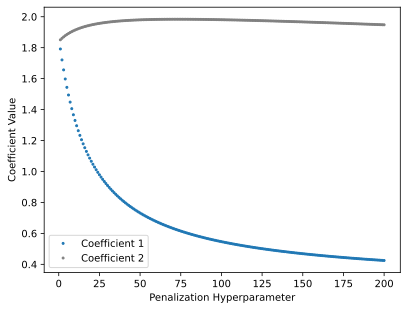

In [ ]:
plt.plot(mu_values, coef1_values_rid , 'o', label='Coefficient 1',markersize = 2 )
plt.plot(mu_values, coef2_values_rid , 'o', label='Coefficient 2', markersize = 2, color = "grey")
plt.xlabel('Penalization Hyperparameter')
plt.ylabel('Coefficient Value')
plt.legend()
plt.show()

 **Dynamics of Ridge Penalization**
*EVEN FOR LARGE PENALIZATION ( LAMBDA = 200 ) , WE DO NOT GET SPARSITY.*


 **Applying Ridge penalty on dataset**

In [ ]:
class RidgeMse :

    def __init__(self, mu = 0.1 ):
        self.mu = mu

    def set_params(self, **params):
        for param in params.keys():
            setattr(self, param, params[param])
        return self

    def fit(self, X, y):
      X = np.array(X)
      n = X.shape[1]
      y = np.array(y)

      def quad_grad(beta):
        return np.dot(X.T, (np.dot(X, beta) - y))

      def prox_ridge(beta, t):
        return  beta /(1 + t  * self.mu)

      coef_ridge_mse = apg.solve(quad_grad, prox_ridge, np.zeros(n), use_restart=True, eps=1e-12, quiet=True)
      self.coef = coef_ridge_mse

      return self

    def predict(self, X):
        return np.dot(X, self.coef)


In [ ]:
params = {'mu': np.linspace(0.1,100,7).tolist()}

In [ ]:
RidgeMse = val_fun(RidgeMse,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld,sleep=3)

Model with params: {'mu': 0.1} finished.
with out-of-sample MSE on validation set: 0.01575
with out-of-sample R-squared on validation set: -53.0346244%
************************************************************
Model with params: {'mu': 16.750000000000004} finished.
with out-of-sample MSE on validation set: 0.01386
with out-of-sample R-squared on validation set: -28.9332824%
************************************************************
Model with params: {'mu': 33.400000000000006} finished.
with out-of-sample MSE on validation set: 0.01448
with out-of-sample R-squared on validation set: -37.4671985%
************************************************************
Model with params: {'mu': 50.050000000000004} finished.
with out-of-sample MSE on validation set: 0.01379
with out-of-sample R-squared on validation set: -28.9478054%
************************************************************
Model with params: {'mu': 66.7} finished.
with out-of-sample MSE on validation set: 0.01413
with out-of

In [ ]:
#evaluate
evaluate(y_tst, RidgeMse.predict(X_tst))

***************Out-of-Sample Metrics***************
The out-of-sample R2 is -48.36%
The out-of-sample MSE is 0.012


 **Ridge with huber loss**

In [ ]:
class RidgeHuber :

    def __init__(self, mu = 0.1 ,delta = 0.02):
        self.mu = mu
        self.delta = delta

    def set_params(self, **params):
        for param in params.keys():
            setattr(self, param, params[param])
        return self

    def fit(self, X, y):
      X = np.array(X)
      n = X.shape[1]
      y = np.array(y)

      def huber_loss_gradient(beta):
        residual = np.dot(X, beta) - y
        huber_grad = np.dot(X.T, np.where(np.abs(residual) <= self.delta, residual, self.delta * np.sign(residual)))
        return huber_grad

      def prox_ridge(beta, t):
        return  beta /(1 + t  * self.mu)

      coef_ridge_mse = apg.solve(huber_loss_gradient, prox_ridge, np.zeros(n), use_restart=True, eps=1e-12, quiet=True)
      self.coef = coef_ridge_mse

      return self

    def predict(self, X):
        return np.dot(X, self.coef)

In [ ]:
params = {'mu': np.linspace(0.1,100,7).tolist(),'delta':np.array([0.02, 0.03, 0.05, 0.1]) }
RidgeHuber = val_fun(RidgeHuber,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld,sleep=3)

/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.02, 'mu': 0.1} finished.
with out-of-sample MSE on validation set: 0.01529
with out-of-sample R-squared on validation set: -53.8359054%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.02, 'mu': 16.750000000000004} finished.
with out-of-sample MSE on validation set: 0.01312
with out-of-sample R-squared on validation set: -28.9199654%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.02, 'mu': 33.400000000000006} finished.
with out-of-sample MSE on validation set: 0.01320
with out-of-sample R-squared on validation set: -31.4348442%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.02, 'mu': 50.050000000000004} finished.
with out-of-sample MSE on validation set: 0.01247
with out-of-sample R-squared on validation set: -23.3909580%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.02, 'mu': 66.7} finished.
with out-of-sample MSE on validation set: 0.01187
with out-of-sample R-squared on validation set: -16.4688314%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.02, 'mu': 83.35000000000001} finished.
with out-of-sample MSE on validation set: 0.01158
with out-of-sample R-squared on validation set: -13.6865254%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.02, 'mu': 100.0} finished.
with out-of-sample MSE on validation set: 0.01133
with out-of-sample R-squared on validation set: -11.0880776%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.03, 'mu': 0.1} finished.
with out-of-sample MSE on validation set: 0.01346
with out-of-sample R-squared on validation set: -31.6944439%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.03, 'mu': 16.750000000000004} finished.
with out-of-sample MSE on validation set: 0.01299
with out-of-sample R-squared on validation set: -26.8028000%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.03, 'mu': 33.400000000000006} finished.
with out-of-sample MSE on validation set: 0.01362
with out-of-sample R-squared on validation set: -35.4471456%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.03, 'mu': 50.050000000000004} finished.
with out-of-sample MSE on validation set: 0.01308
with out-of-sample R-squared on validation set: -29.7272164%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.03, 'mu': 66.7} finished.
with out-of-sample MSE on validation set: 0.01240
with out-of-sample R-squared on validation set: -21.8874363%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.03, 'mu': 83.35000000000001} finished.
with out-of-sample MSE on validation set: 0.01227
with out-of-sample R-squared on validation set: -20.9374143%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.03, 'mu': 100.0} finished.
with out-of-sample MSE on validation set: 0.01189
with out-of-sample R-squared on validation set: -16.6791783%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.05, 'mu': 0.1} finished.
with out-of-sample MSE on validation set: 0.01491
with out-of-sample R-squared on validation set: -48.3333151%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.05, 'mu': 16.750000000000004} finished.
with out-of-sample MSE on validation set: 0.01333
with out-of-sample R-squared on validation set: -29.8109984%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.05, 'mu': 33.400000000000006} finished.
with out-of-sample MSE on validation set: 0.01346
with out-of-sample R-squared on validation set: -32.0205583%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.05, 'mu': 50.050000000000004} finished.
with out-of-sample MSE on validation set: 0.01287
with out-of-sample R-squared on validation set: -25.3407117%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.05, 'mu': 66.7} finished.
with out-of-sample MSE on validation set: 0.01347
with out-of-sample R-squared on validation set: -33.2709922%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.05, 'mu': 83.35000000000001} finished.
with out-of-sample MSE on validation set: 0.01259
with out-of-sample R-squared on validation set: -22.7869607%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.05, 'mu': 100.0} finished.
with out-of-sample MSE on validation set: 0.01260
with out-of-sample R-squared on validation set: -23.5191070%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.1, 'mu': 0.1} finished.
with out-of-sample MSE on validation set: 0.01388
with out-of-sample R-squared on validation set: -30.8292498%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.1, 'mu': 16.750000000000004} finished.
with out-of-sample MSE on validation set: 0.01472
with out-of-sample R-squared on validation set: -41.4441382%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.1, 'mu': 33.400000000000006} finished.
with out-of-sample MSE on validation set: 0.01352
with out-of-sample R-squared on validation set: -27.4310527%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.1, 'mu': 50.050000000000004} finished.
with out-of-sample MSE on validation set: 0.01373
with out-of-sample R-squared on validation set: -30.4889912%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.1, 'mu': 66.7} finished.
with out-of-sample MSE on validation set: 0.01337
with out-of-sample R-squared on validation set: -26.5158879%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.1, 'mu': 83.35000000000001} finished.
with out-of-sample MSE on validation set: 0.01309
with out-of-sample R-squared on validation set: -23.5499530%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.1, 'mu': 100.0} finished.
with out-of-sample MSE on validation set: 0.01319
with out-of-sample R-squared on validation set: -25.2179147%
************************************************************

############################################################
Tuning process finished!!!
The best setting is: {'delta': 0.02, 'mu': 100.0}
with MSE OOS 0.01133 on validation set.
############################################################


I evaluate on new tuning parameters.
The choice of the new parameters was done after evaluating the previous fit. (Note I mistakenly deleted the previous evaluation results)  

In [ ]:
params = {'mu': (np.logspace(np.log10(100), np.log10(800), 4)).tolist(), 'delta': [0.025]}

In [ ]:
RidgeHuber = val_fun(RidgeHuber,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld,sleep=3)

/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.025, 'mu': 100.0} finished.
with out-of-sample MSE on validation set: 0.01161
with out-of-sample R-squared on validation set: -13.8047403%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.025, 'mu': 200.00000000000003} finished.
with out-of-sample MSE on validation set: 0.01076
with out-of-sample R-squared on validation set: -5.9198186%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.025, 'mu': 400.0000000000001} finished.
with out-of-sample MSE on validation set: 0.01008
with out-of-sample R-squared on validation set: -0.8996482%
************************************************************


/usr/local/lib/python3.10/dist-packages/apgpy.py:93: RuntimeWarning: divide by zero encountered in double_scalars
  t_hat = 0.5 * ((y - y_old).norm() ** 2) / abs((y - y_old).dot(g_old - g))


Model with params: {'delta': 0.025, 'mu': 800.0000000000003} finished.
with out-of-sample MSE on validation set: 0.00959
with out-of-sample R-squared on validation set: 1.6841290%
************************************************************

############################################################
Tuning process finished!!!
The best setting is: {'delta': 0.025, 'mu': 800.0000000000003}
with MSE OOS 0.00959 on validation set.
############################################################


In [ ]:
 evaluate(y_tst, RidgeHuber.predict(X_tst))

***************Out-of-Sample Metrics***************
The out-of-sample R2 is -5.62371%
The out-of-sample MSE is 0.00876974


**Generalized additive model using second order splines**

I first install the group lasso package then regresss using GLM with group lasso using 2nd order splines

In [ ]:
pip install group_lasso


In [ ]:
from group_lasso import GroupLasso

def flatten(l):
    return [item for sublist in l for item in sublist]

def SplineTransform(data,knots=3):
    spline_data = pd.DataFrame(np.ones((data.shape[0],1)),index=data.index,columns=['const'])
    for i in data.columns:
        i_dat = data.loc[:,i]
        i_sqr = i_dat**2
        i_cut, bins = pd.cut(i_dat, 3, right=True, ordered=True, retbins=True)
        i_dum = pd.get_dummies(i_cut)
        for j in np.arange(knots):
            i_dum.iloc[:,j] = i_dum.iloc[:,j]*((i_dat-bins[j])**2)
        i_dum.columns = [f"{i}_{k}" for k in np.arange(1,knots+1)]
        spline_data = pd.concat((spline_data,i_dat,i_dum),axis=1)
    return spline_data

class GLMRegression:

    def __init__(self,knots=3,lmd=1e-4,l1_reg=1e-4,random_state=12308):
        self.knots = knots
        self.lmd = lmd
        self.random_state = random_state
        self.l1_reg = l1_reg

    def set_params(self, **params):
        for param in params.keys():
            setattr(self, param, params[param])
        return self

    def fit(self,X,y):
        groups = [0]+flatten([list(np.repeat(i,self.knots+1))[:] for i in np.arange(1,X.shape[1]+1)])
        X = SplineTransform(X)
        self.mod = GroupLasso(
            groups=groups,group_reg=self.lmd,l1_reg=self.l1_reg,
            fit_intercept=False,random_state=self.random_state
        )
        self.mod = self.mod.fit(X,y)
        return self

    def predict(self,X):
        X = SplineTransform(X)
        return self.mod.predict(X)

In [ ]:
params = { 'knots':[3], 'lmd':[1e-4,1e-1], 'l1_reg':[1e-4,0]}
GLM = val_fun(GLMRegression,params=params,X_trn=X_trn,y_trn=y_trn,X_vld=X_vld,y_vld=y_vld)

<ipython-input-22-689b80485cda>:14: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  i_dum.iloc[:,j] = i_dum.iloc[:,j]*((i_dat-bins[j])**2)
<ipython-input-22-689b80485cda>:14: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  i_dum.iloc[:,j] = i_dum.iloc[:,j]*((i_dat-bins[j])**2)
<ipython-input-22-689b80485cda>:14: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non

Model with params: {'knots': 3, 'l1_reg': 0.0001, 'lmd': 0.0001} finished.
with out-of-sample MSE on validation set: 0.00903
with out-of-sample R-squared on validation set: 0.5840259%
************************************************************


<ipython-input-22-689b80485cda>:14: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  i_dum.iloc[:,j] = i_dum.iloc[:,j]*((i_dat-bins[j])**2)
<ipython-input-22-689b80485cda>:14: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  i_dum.iloc[:,j] = i_dum.iloc[:,j]*((i_dat-bins[j])**2)
<ipython-input-22-689b80485cda>:14: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non

Model with params: {'knots': 3, 'l1_reg': 0.0001, 'lmd': 0.1} finished.
with out-of-sample MSE on validation set: 0.00876
with out-of-sample R-squared on validation set: 0.0000000%
************************************************************


<ipython-input-22-689b80485cda>:14: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  i_dum.iloc[:,j] = i_dum.iloc[:,j]*((i_dat-bins[j])**2)
<ipython-input-22-689b80485cda>:14: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  i_dum.iloc[:,j] = i_dum.iloc[:,j]*((i_dat-bins[j])**2)
<ipython-input-22-689b80485cda>:14: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non

Model with params: {'knots': 3, 'l1_reg': 0, 'lmd': 0.0001} finished.
with out-of-sample MSE on validation set: 0.00915
with out-of-sample R-squared on validation set: 0.5351145%
************************************************************


<ipython-input-22-689b80485cda>:14: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  i_dum.iloc[:,j] = i_dum.iloc[:,j]*((i_dat-bins[j])**2)
<ipython-input-22-689b80485cda>:14: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  i_dum.iloc[:,j] = i_dum.iloc[:,j]*((i_dat-bins[j])**2)
<ipython-input-22-689b80485cda>:14: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non

Model with params: {'knots': 3, 'l1_reg': 0, 'lmd': 0.1} finished.
with out-of-sample MSE on validation set: 0.00876
with out-of-sample R-squared on validation set: 0.0000000%
************************************************************

############################################################
Tuning process finished!!!
The best setting is: {'knots': 3, 'l1_reg': 0.0001, 'lmd': 0.1}
with MSE OOS 0.00876 on validation set.
############################################################


In [ ]:
evaluate(y_tst, GLM.predict(X_tst))

<ipython-input-22-689b80485cda>:14: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  i_dum.iloc[:,j] = i_dum.iloc[:,j]*((i_dat-bins[j])**2)
<ipython-input-22-689b80485cda>:14: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  i_dum.iloc[:,j] = i_dum.iloc[:,j]*((i_dat-bins[j])**2)
<ipython-input-22-689b80485cda>:14: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non

***************Out-of-Sample Metrics***************
The out-of-sample R2 is 0.00000%
The out-of-sample MSE is 0.00868181


In [ ]:
class GLMRegressionHuber:

    def __init__(self, knots=3, lmd=1e-4, l1_reg=1e-4, random_state=12308, huber_delta=1.0):
        self.knots = knots
        self.lmd = lmd
        self.random_state = random_state
        self.l1_reg = l1_reg
        self.huber_delta = huber_delta

    def set_params(self, **params):
        for param in params.keys():
            setattr(self, param, params[param])
        return self

    def fit(self, X, y):
        groups = [0] + flatten([list(np.repeat(i, self.knots + 1))[:] for i in np.arange(1, X.shape[1] + 1)])
        X_transformed = SplineTransform(X)

        # Introduce Huber loss
        huber_loss = lambda x: 0.5 * x**2 if np.abs(x) <= self.huber_delta else self.huber_delta * (np.abs(x) - 0.5 * self.huber_delta)

        self.mod = GroupLasso(
            groups=groups, group_reg=self.lmd, l1_reg=self.l1_reg,
            fit_intercept=False, random_state=self.random_state, loss=huber_loss
        )
        self.mod = self.mod.fit(X_transformed, y)
        return self

    def predict(self, X):
        X_transformed = SplineTransform(X)
        return self.mod.predict(X_transformed)

In [ ]:
params = {'knots': [3], 'lmd': [1e-4, 1e-1], 'l1_reg': [1e-4, 0], 'huber_delta': [1.0, 0.5]}
GLM_H = val_fun(GLMRegression, params=params, X_trn=X_trn, y_trn=y_trn, X_vld=X_vld, y_vld=y_vld)


<ipython-input-10-689b80485cda>:14: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  i_dum.iloc[:,j] = i_dum.iloc[:,j]*((i_dat-bins[j])**2)
<ipython-input-10-689b80485cda>:14: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  i_dum.iloc[:,j] = i_dum.iloc[:,j]*((i_dat-bins[j])**2)
<ipython-input-10-689b80485cda>:14: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non

Model with params: {'huber_delta': 1.0, 'knots': 3, 'l1_reg': 0.0001, 'lmd': 0.0001} finished.
with out-of-sample MSE on validation set: 0.00903
with out-of-sample R-squared on validation set: 0.5840259%
************************************************************


<ipython-input-10-689b80485cda>:14: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  i_dum.iloc[:,j] = i_dum.iloc[:,j]*((i_dat-bins[j])**2)
<ipython-input-10-689b80485cda>:14: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  i_dum.iloc[:,j] = i_dum.iloc[:,j]*((i_dat-bins[j])**2)
<ipython-input-10-689b80485cda>:14: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non

Model with params: {'huber_delta': 1.0, 'knots': 3, 'l1_reg': 0.0001, 'lmd': 0.1} finished.
with out-of-sample MSE on validation set: 0.00876
with out-of-sample R-squared on validation set: 0.0000000%
************************************************************


<ipython-input-10-689b80485cda>:14: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  i_dum.iloc[:,j] = i_dum.iloc[:,j]*((i_dat-bins[j])**2)
<ipython-input-10-689b80485cda>:14: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  i_dum.iloc[:,j] = i_dum.iloc[:,j]*((i_dat-bins[j])**2)
<ipython-input-10-689b80485cda>:14: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non

Model with params: {'huber_delta': 1.0, 'knots': 3, 'l1_reg': 0, 'lmd': 0.0001} finished.
with out-of-sample MSE on validation set: 0.00915
with out-of-sample R-squared on validation set: 0.5351145%
************************************************************


<ipython-input-10-689b80485cda>:14: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  i_dum.iloc[:,j] = i_dum.iloc[:,j]*((i_dat-bins[j])**2)
<ipython-input-10-689b80485cda>:14: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  i_dum.iloc[:,j] = i_dum.iloc[:,j]*((i_dat-bins[j])**2)
<ipython-input-10-689b80485cda>:14: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non

Model with params: {'huber_delta': 1.0, 'knots': 3, 'l1_reg': 0, 'lmd': 0.1} finished.
with out-of-sample MSE on validation set: 0.00876
with out-of-sample R-squared on validation set: 0.0000000%
************************************************************


<ipython-input-10-689b80485cda>:14: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  i_dum.iloc[:,j] = i_dum.iloc[:,j]*((i_dat-bins[j])**2)
<ipython-input-10-689b80485cda>:14: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  i_dum.iloc[:,j] = i_dum.iloc[:,j]*((i_dat-bins[j])**2)
<ipython-input-10-689b80485cda>:14: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non

KeyboardInterrupt: 

In [ ]:
evaluate(y_tst, GLM_H.predict(X_tst))

**CODE FOR PCA VS ICA on dataset(PLOTS)**

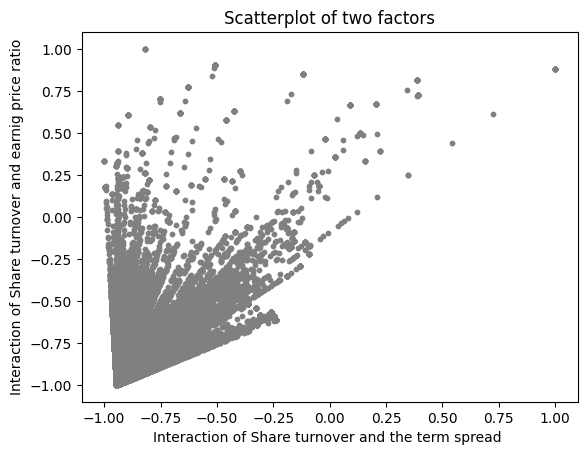

In [ ]:
plt.scatter(X_trn['turn*tms'], X_trn['turn*ep'], color='grey', s=10)
plt.xlabel('Interaction of Share turnover and the term spread ')
plt.ylabel('Interaction of Share turnover and earnig price ratio')
plt.title('Scatterplot of two factors')
plt.show()

In [ ]:
X1 = np.array(X_trn['turn*tms'])
X2 = np.array(X_trn['turn*ep'])
X_design= np.column_stack((X1, X2))

In [ ]:
X = (X_design - np.mean(X_design))/np.std(X_design)

In [ ]:
pca = PCA()
S_pca_ = pca.fit(X).transform(X)

ica = FastICA(whiten="unit-variance")
S_ica_ = ica.fit(X).transform(X)  # Estimate the sources

In [ ]:
import matplotlib.pyplot as plt

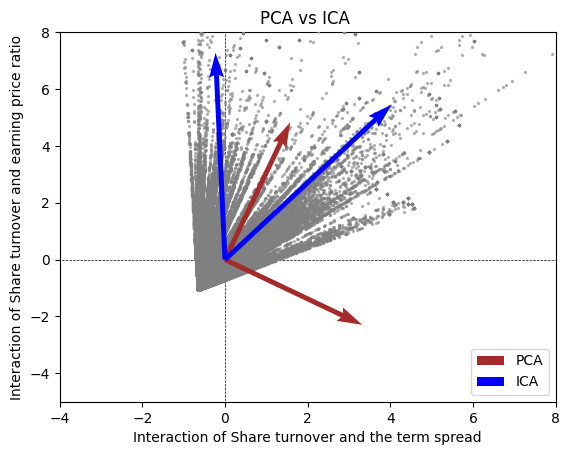

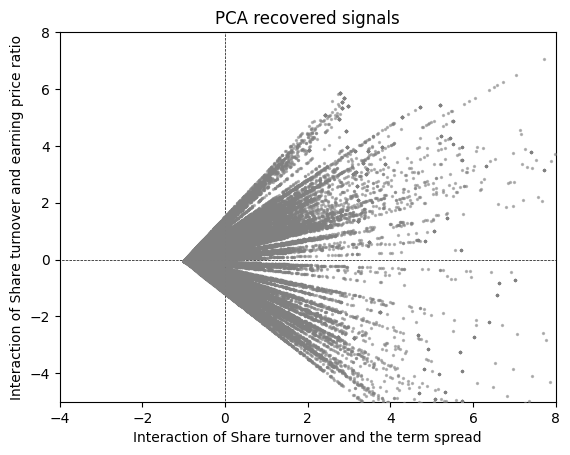

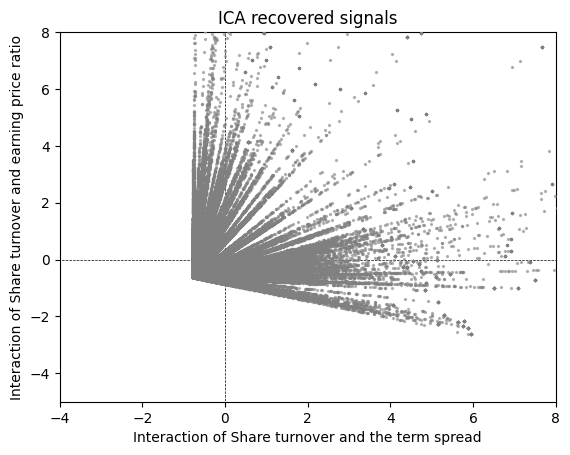

In [ ]:
def plot_samples(S, axis_list=None):
    plt.scatter(
        S[:, 0], S[:, 1], s=2, marker="o", zorder=10, color="grey", alpha=0.5
    )
    if axis_list is not None:
        for axis, color, label in axis_list:
            axis /= axis.std()
            x_axis, y_axis = axis
            plt.quiver(
                (0, 0),
                (0, 0),
                x_axis,
                y_axis,
                zorder=11,
                width=0.01,
                scale=6,
                color=color,
                label=label,
            )

    plt.hlines(0, -10, 10, linestyles='dashed', colors='black', linewidth=0.5)
    plt.vlines(0, -10, 10, linestyles='dashed', colors='black', linewidth=0.5)
    plt.xlim(-4, 8)
    plt.ylim(-5, 8)
    plt.xlabel('Interaction of Share turnover and the term spread')
    plt.ylabel('Interaction of Share turnover and earning price ratio')


axis_list = [(pca.components_.T, "brown", "PCA"), (ica.mixing_, "blue", "ICA")]

# Plot 1: Observations
plt.figure()
plot_samples(X, axis_list=axis_list)
legend = plt.legend(loc="lower right")
legend.set_zorder(100)
plt.title("PCA vs ICA ")
plt.savefig('observations_plot.png')  # Save the plot as a PNG file

# Plot 2: PCA recovered signals
plt.figure()
plot_samples(S_pca_ / np.std(S_pca_, axis=0))
plt.title("PCA recovered signals")
plt.savefig('pca_recovered_plot.png')  # Save the plot as a PNG file

# Plot 3: ICA recovered signals
plt.figure()
plot_samples(S_ica_ / np.std(S_ica_))
plt.title("ICA recovered signals")
plt.savefig('ica_recovered_plot.png')  # Save the plot as a PNG file

plt.show()


In [ ]:
import numpy as np

X1 = np.array(X_trn['turn*tms'])
X2 = np.array(X_trn['turn*ep'])
X_design= np.column_stack((X1, X2))
X = (X_design - np.mean(X_design))/np.std(X_design)
pca = PCA()
S_pca_ = pca.fit(X).transform(X)

ica = FastICA(whiten="unit-variance")
S_ica_eg = ica.fit(X).transform(X)  # Estimate the sources
coef_eg = ica.mixing_
'''
import matplotlib.pyplot as plt
def plot_samples(S, axis_list=None):
    plt.scatter(
        S[:, 0], S[:, 1], s=2, marker="o", zorder=10, color="grey", alpha=0.5
    )
    if axis_list is not None:
        for axis, color, label in axis_list:
            axis /= axis.std()
            x_axis, y_axis = axis
            plt.quiver(
                (0, 0),
                (0, 0),
                x_axis,
                y_axis,
                zorder=11,
                width=0.01,
                scale=6,
                color=color,
                label=label,
            )

    plt.hlines(0, -10, 10, linestyles='dashed', colors='black', linewidth=0.5)
    plt.vlines(0, -10, 10, linestyles='dashed', colors='black', linewidth=0.5)
    plt.xlim(-4, 8)
    plt.ylim(-5, 8)
    plt.xlabel('Interaction of Share turnover and the term spread')
    plt.ylabel('Interaction of Share turnover and earning price ratio')


axis_list = [(pca.components_.T, "brown", "PCA"), (ica.mixing_, "blue", "ICA")]

# Plot 1: Observations
plt.figure()
plot_samples(X, axis_list=axis_list)
legend = plt.legend(loc="lower right")
legend.set_zorder(100)
plt.title("PCA vs ICA ")
plt.savefig('observations_plot.png')  # Save the plot as a PNG file

# Plot 2: PCA recovered signals
plt.figure()
plot_samples(S_pca_ / np.std(S_pca_, axis=0))
plt.title("PCA recovered signals")
plt.savefig('pca_recovered_plot.png')  # Save the plot as a PNG file

# Plot 3: ICA recovered signals
plt.figure()
plot_samples(S_ica_ / np.std(S_ica_))
plt.title("ICA recovered signals")
plt.savefig('ica_recovered_plot.png')  # Save the plot as a PNG file

plt.show()
'''

'\nimport matplotlib.pyplot as plt\ndef plot_samples(S, axis_list=None):\n    plt.scatter(\n        S[:, 0], S[:, 1], s=2, marker="o", zorder=10, color="grey", alpha=0.5\n    )\n    if axis_list is not None:\n        for axis, color, label in axis_list:\n            axis /= axis.std()\n            x_axis, y_axis = axis\n            plt.quiver(\n                (0, 0),\n                (0, 0),\n                x_axis,\n                y_axis,\n                zorder=11,\n                width=0.01,\n                scale=6,\n                color=color,\n                label=label,\n            )\n\n    plt.hlines(0, -10, 10, linestyles=\'dashed\', colors=\'black\', linewidth=0.5)\n    plt.vlines(0, -10, 10, linestyles=\'dashed\', colors=\'black\', linewidth=0.5)\n    plt.xlim(-4, 8)\n    plt.ylim(-5, 8)\n    plt.xlabel(\'Interaction of Share turnover and the term spread\')\n    plt.ylabel(\'Interaction of Share turnover and earning price ratio\')\n\n\naxis_list = [(pca.components_.T, 

In [ ]:
print(S_ica_eg.shape)
print(coef_eg.shape )

(96000, 2)
(2, 2)


In [ ]:
sources_trans = S_ica_eg.T
print(sources_trans.shape)
squared_source_matrix = np.square(sources_trans)
print(squared_source_matrix.shape)


(2, 96000)
(2, 96000)


In [ ]:
squared_A = np.square(coef_eg)
print(squared_A)
# Compute the sum of squared elements for each column q
sum_squared_elements = np.sum(squared_A, axis=0)
print(sum_squared_elements.shape)
result_matrix = sum_squared_elements.reshape(1, -1)
print(result_matrix.shape)


[[0.58352864 0.00186423]
 [0.50382962 0.89789468]]
(2,)
(1, 2)


In [ ]:
qd_matrix =   result_matrix.T * squared_source_matrix
mean_per_row = np.mean(qd_matrix, axis=1, keepdims=True)
print(mean_per_row.shape)
print(mean_per_row)

(2, 1)
[[1.08735826]
 [0.89975891]]


In [ ]:
sorted_indices = np.argsort(mean_per_row.flatten())[::-1]
print(sorted_indices)

[0 1]


In [ ]:
selected_indices = np.argsort(mean_per_row.flatten())[::-1][:n_selected].tolist()

In [ ]:
selected_indices = np.argsort(mean_per_row.flatten())[::-1][:1].tolist()
print(selected_indices)

[0]
